#### Author: Justin Bloesch

Plotting, Analysis and EDA

In [1]:
import numpy as np
import pandas as pd
import warnings
import darts as dts
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_squared_error
from math import sqrt
from pmdarima.arima import auto_arima
from pandas.plotting import autocorrelation_plot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates

matplotlib.rc_file_defaults()
pd.set_option('display.max_colwidth', None)
pd. set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#Load SA Demand data set
demand_sa_df = pd.read_csv('totaldemand_sa.csv')

In [3]:
#Convert DATETIME string to type datetime 
demand_sa_df['DATETIME'] = pd.to_datetime(demand_sa_df['DATETIME'])

#Break down Timestamp into new attributes
demand_sa_df['YEAR'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).year
demand_sa_df['MONTH'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).month

In [4]:
#Get 48 time steps of actual demand to compare to winter forecast
iloc = ((demand_sa_df['DATETIME'] > '2020-08-07 04:00:00')) 

#Generate and capture 48 time steps of demand greater than forecast data
actual_demand_winter_2020_sa_df = demand_sa_df.loc[iloc]
actual_demand_winter_2020_sa_48_ts_df = actual_demand_winter_2020_sa_df.head(48)

In [5]:
#Load SA LSTM winter 48 time step forecast data set
LSTM_winter_forecast_df = pd.read_csv('winter_lstm_results.csv')

In [6]:
#Evaluate LSTM winter demand 48 time steps forecasts
rmseLSTM_winter = sqrt(mean_squared_error(actual_demand_winter_2020_sa_48_ts_df['TOTALDEMAND'], LSTM_winter_forecast_df['LSTM_Predictions'])) 
print('RMSE LSTM Winter Demand Forecast (48 ts): %.3f MW' % rmseLSTM_winter)

RMSE LSTM Winter Demand Forecast (48 ts): 221.893 MW


In [7]:
# Define the function to return the MAPE values
def calc_mape(actual, predicted) -> float:
  
    # Convert actual and predicted
    # to numpy array data type if not already
    if not all([isinstance(actual, np.ndarray),
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual), 
        np.array(predicted)
  
    # Calculate the MAPE value and return
    return round(np.mean(np.abs((
      actual - predicted) / actual)) * 100, 4)

In [8]:
mapeLSTM_winter = calc_mape(actual_demand_winter_2020_sa_48_ts_df['TOTALDEMAND'].values, LSTM_winter_forecast_df['LSTM_Predictions'].values)
print('MAPE LSTM Winter Demand Forecast (48 ts): %.4f' % mapeLSTM_winter+'%')
LSTM_model_explained = 100 - mapeLSTM_winter
print('LSTM Explained Winter Demand (48 ts): %.3f' % LSTM_model_explained+'%')

MAPE LSTM Winter Demand Forecast (48 ts): 10.2675%
LSTM Explained Winter Demand (48 ts): 89.733%


In [9]:
#TFT

#Load TFT winter predictions
TFT_winter_forecast_df = pd.read_csv('TFT_predictions_winter2020.csv')

In [10]:
#Subset runs to average predictions
TFT_winter_forecast_subset_df = TFT_winter_forecast_df[['Run1','Run2','Run3','Run4','Run5','Run6','Run7','Run8', 'Run9', 'Run10']]

In [11]:
TFT_winter_forecast_subset_df.head()

,Run1,Run2,Run3,Run4,Run5,Run6,Run7,Run8,Run9,Run10
0,1421.3351,1319.3794,1337.3834,1373.5300,1284.2832,1396.7678,1336.7764,1326.1427,1311.5339,1325.9362
1,1421.5673,1331.8340,1338.1179,1354.8967,1308.4623,1395.9703,1346.4823,1355.5658,1335.1526,1342.8372
2,1418.8176,1327.7162,1346.1722,1353.7000,1336.8015,1399.6395,1336.3315,1359.5465,1336.9133,1363.7943
3,1447.3989,1332.0447,1388.4626,1378.4961,1389.4517,1435.5509,1352.8090,1396.5978,1369.3589,1425.5431
4,1523.8387,1364.1206,1469.1685,1451.0640,1476.3566,1520.2335,1419.4470,1483.8943,1441.0513,1516.5693


In [12]:
TFT_winter_forecast_subset_df['TFT'] = TFT_winter_forecast_subset_df.mean(axis=1)

In [13]:
TFT_winter_forecast_subset_df.head()

,Run1,Run2,Run3,Run4,Run5,Run6,Run7,Run8,Run9,Run10,TFT
0,1421.3351,1319.3794,1337.3834,1373.5300,1284.2832,1396.7678,1336.7764,1326.1427,1311.5339,1325.9362,1343.30681
1,1421.5673,1331.8340,1338.1179,1354.8967,1308.4623,1395.9703,1346.4823,1355.5658,1335.1526,1342.8372,1353.08864
2,1418.8176,1327.7162,1346.1722,1353.7000,1336.8015,1399.6395,1336.3315,1359.5465,1336.9133,1363.7943,1357.94326
3,1447.3989,1332.0447,1388.4626,1378.4961,1389.4517,1435.5509,1352.8090,1396.5978,1369.3589,1425.5431,1391.57137
4,1523.8387,1364.1206,1469.1685,1451.0640,1476.3566,1520.2335,1419.4470,1483.8943,1441.0513,1516.5693,1466.57438


In [14]:
#Evaluate TFT winter demand 48 time steps forecasts
rmseTFT_winter = sqrt(mean_squared_error(actual_demand_winter_2020_sa_48_ts_df['TOTALDEMAND'], TFT_winter_forecast_subset_df['TFT'])) 
print('RMSE TFT Winter Demand Forecast (48 ts): %.3f MW' % rmseTFT_winter)

RMSE TFT Winter Demand Forecast (48 ts): 299.898 MW


In [15]:
mapeTFT_winter = calc_mape(actual_demand_winter_2020_sa_48_ts_df['TOTALDEMAND'].values, TFT_winter_forecast_subset_df['TFT'].values)
print('MAPE TFT Winter Demand Forecast (48 ts): %.3f' % mapeTFT_winter+'%')
TFT_model_explained = 100 - mapeTFT_winter
print('TFT Explained Winter Demand (48 ts): %.3f' % TFT_model_explained+'%')

MAPE TFT Winter Demand Forecast (48 ts): 11.124%
TFT Explained Winter Demand (48 ts): 88.876%


In [16]:
#SARIMA

In [17]:
#Get preceding winter training data up to 7 Aug 0400 hrs 2020
iloc = (demand_sa_df['DATETIME'] >= '2020-06-01 00:00:00') & (demand_sa_df['DATETIME'] <= '2020-08-07 04:00:00')

#Create and capture winter training demand 2020
demand_sa_train_winter = demand_sa_df.loc[iloc]

In [18]:
#Build final SARIMA model
model_winter = ARIMA(demand_sa_train_winter['TOTALDEMAND'], order=(3, 0, 0), seasonal_order=(1, 0, 1, 48))
model_winter_fit = model_winter.fit()

In [19]:
#SARIMA Forecast 48 30min time steps
forecast_winter_48_ts = model_winter_fit.get_forecast(48, alpha=0.05).summary_frame()

In [20]:
#Evaluate winter demand 48 time steps forecasts
rmseARIMA_winter = sqrt(mean_squared_error(actual_demand_winter_2020_sa_48_ts_df['TOTALDEMAND'], forecast_winter_48_ts['mean'])) 
print('RMSE SARIMA Winter Demand Forecast (48 ts): %.3f MW' % rmseARIMA_winter)

RMSE SARIMA Winter Demand Forecast (48 ts): 397.082 MW


In [21]:
mapeSARIMA_winter = calc_mape(actual_demand_winter_2020_sa_48_ts_df['TOTALDEMAND'].values, forecast_winter_48_ts['mean'].values)
print('MAPE SARIMA Winter Demand Forecast (48 ts): %.4f' % mapeSARIMA_winter+'%')
SARIMA_model_explained = 100 - mapeSARIMA_winter
print('SARIMA Explained Winter Demand (48 ts): %.3f' % SARIMA_model_explained+'%')

MAPE SARIMA Winter Demand Forecast (48 ts): 15.0087%
SARIMA Explained Winter Demand (48 ts): 84.991%


In [22]:
#Prepare demand forecast data for plotting

#Get actual demand from 05.08.2020 10000 hrs til final prediction forcast time 08.08.2020 0400 hrs
iloc = (demand_sa_df['DATETIME'] >= '2020-08-05 10:00:00') & (demand_sa_df['DATETIME'] <= '2020-08-08 04:00:00')
truth_demand_df = demand_sa_df.loc[iloc]
truth_demand_df['TIMEstrg'] = truth_demand_df['DATETIME'].dt.strftime('%Y-%m-%d %H:%M')

#Get and prepare 48 time step ARIMA forecast demand between 07.08.2020 0400 hrs and 08.08.2020 0400 hrs 
forecast_ARIMA_series = forecast_winter_48_ts['mean'].reset_index(drop=True)
time_series = actual_demand_winter_2020_sa_48_ts_df['DATETIME'].reset_index(drop=True)
forecast_winter_df = pd.concat([forecast_ARIMA_series, time_series], axis=1).rename(columns={'mean': 'SARIMA', 'DATETIME': 'TIME'})
forecast_winter_df['TIMEstrg'] = forecast_winter_df['TIME'].dt.strftime('%Y-%m-%d %H:%M')

#Get and prepare 48 time step TFT forecast demand between 07.08.2020 0400 hrs and 08.08.2020 0400 hrs
forecast_winter_df = forecast_winter_df.join(TFT_winter_forecast_subset_df['TFT'])

#Get and prepare 48 time step LSTM forecast demand between 07.08.2020 0400 hrs and 08.08.2020 0400 hrs
LSTM_winter_forecast_df.rename(columns = {'LSTM_Predictions':'LSTM'}, inplace = True)
forecast_winter_df = forecast_winter_df.join(LSTM_winter_forecast_df['LSTM'])

#Remove TIME Column
forecast_winter_df.drop(['TIME'], axis=1, inplace=True)

In [23]:
forecast_winter_df.head()

,SARIMA,TIMEstrg,TFT,LSTM
0,1332.589590,2020-08-07 04:30,1343.30681,1574.8230
1,1323.090767,2020-08-07 05:00,1353.08864,1535.6540
2,1328.964120,2020-08-07 05:30,1357.94326,1524.1167
3,1361.091938,2020-08-07 06:00,1391.57137,1529.8150
4,1413.233633,2020-08-07 06:30,1466.57438,1545.9138


In [24]:
#AEMO SA Forecast demand between 07.08.2020 0400 hrs and 08.08.2020 0400 hrs
aemo_forecast_df = pd.read_csv('forecastdemand_sa.csv')
aemo_forecast_df['DATETIME'] = pd.to_datetime(aemo_forecast_df['DATETIME']) 
aemo_forecast_df['LASTCHANGED'] = pd.to_datetime(aemo_forecast_df['LASTCHANGED'])

iloc = (aemo_forecast_df['LASTCHANGED'] == '2020-08-07 04:01:25')
aemo_forecast_subset_df = aemo_forecast_df.loc[iloc].head(48)

aemo_forecast_subset_df['TIMEstrg'] = aemo_forecast_subset_df['DATETIME'].dt.strftime('%Y-%m-%d %H:%M')

In [25]:
#Evaluate AEMO winter  48 time steps forecasts
rmseAEMO_winter = sqrt(mean_squared_error(actual_demand_winter_2020_sa_48_ts_df['TOTALDEMAND'], aemo_forecast_subset_df['FORECASTDEMAND'])) 
print('RMSE AEMO Winter Demand Forecast (48 ts): %.3f MW' % rmseAEMO_winter)

RMSE AEMO Winter Demand Forecast (48 ts): 142.256 MW


In [26]:
mapeAEMO_winter = calc_mape(actual_demand_winter_2020_sa_48_ts_df['TOTALDEMAND'].values, aemo_forecast_subset_df['FORECASTDEMAND'].values)
print('MAPE AEMO Winter Demand Forecast (48 ts): %.3f' % mapeAEMO_winter+'%')
AEMO_model_explained = 100 - mapeAEMO_winter
print('AEMO Explained Winter Demand (48 ts): %.3f' % AEMO_model_explained+'%')

MAPE AEMO Winter Demand Forecast (48 ts): 5.521%
AEMO Explained Winter Demand (48 ts): 94.479%


In [27]:
#Plot winter models forecasts


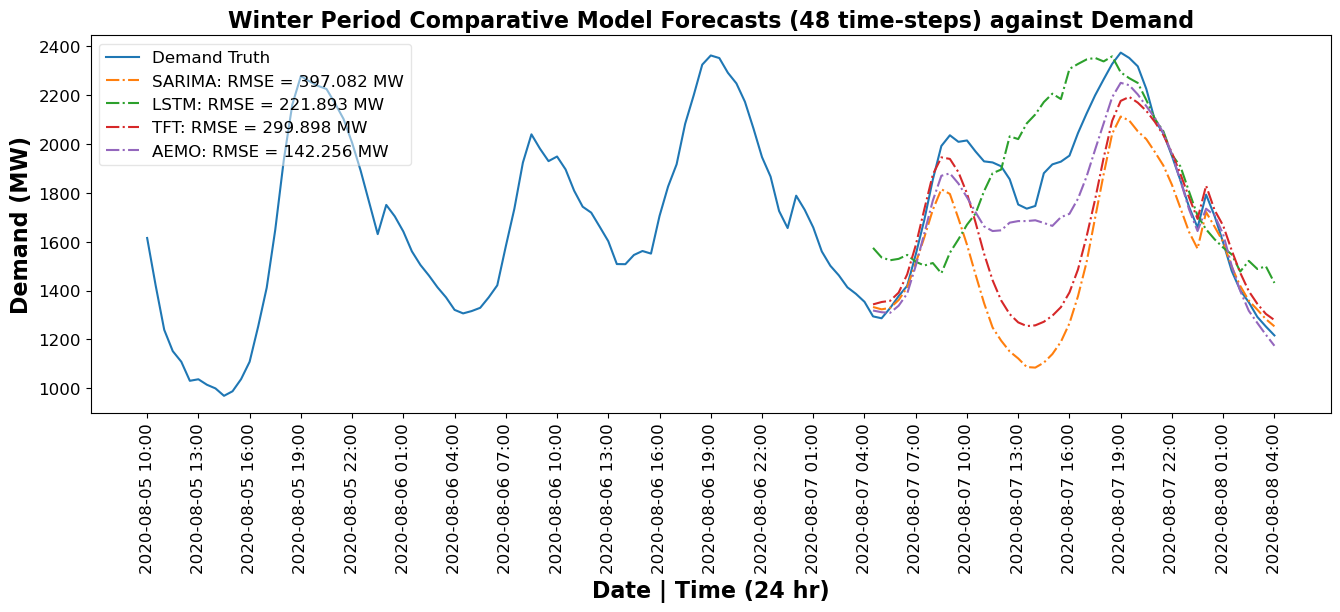

In [28]:
#Comparative demand forecast plot

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_df['TIMEstrg'], truth_demand_df['TOTALDEMAND'], label='Demand Truth')
plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['SARIMA'], linestyle='-.', label='SARIMA: RMSE = %.3f MW' % rmseARIMA_winter)
plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['LSTM'], linestyle='-.', label='LSTM: RMSE = %.3f MW' % rmseLSTM_winter)
plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['TFT'], linestyle='-.', label='TFT: RMSE = %.3f MW' % rmseTFT_winter)
plt_plot.plot(aemo_forecast_subset_df['TIMEstrg'], aemo_forecast_subset_df['FORECASTDEMAND'], linestyle='-.', label='AEMO: RMSE = %.3f MW' % rmseAEMO_winter)

#plt.xticks(rotation='vertical')
plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::6])
plt_plot.set_xticklabels(xStrg[::6], rotation='vertical')
plt.title('Winter Period Comparative Model Forecasts (48 time-steps) against Demand', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('WinterComparePlot.png', bbox_inches='tight')
plt.show()

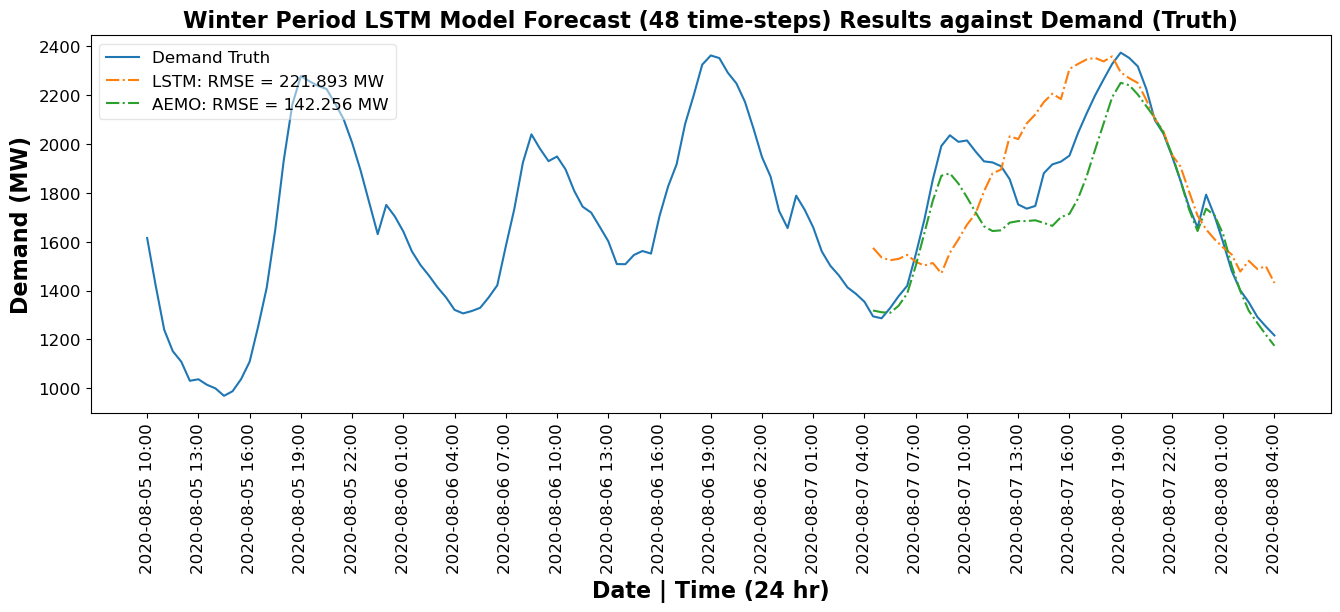

In [32]:
#LSTM Results

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_df['TIMEstrg'], truth_demand_df['TOTALDEMAND'], label='Demand Truth')
plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['LSTM'], linestyle='-.', label='LSTM: RMSE = %.3f MW' % rmseLSTM_winter)
#plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['TFT'], linestyle='-.', label='TFT: RMSE = %.3f MW' % rmseTFT_winter)
plt_plot.plot(aemo_forecast_subset_df['TIMEstrg'], aemo_forecast_subset_df['FORECASTDEMAND'], linestyle='-.', label='AEMO: RMSE = %.3f MW' % rmseAEMO_winter)

#plt.xticks(rotation='vertical')
plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::6])
plt_plot.set_xticklabels(xStrg[::6], rotation='vertical')
plt.title('Winter Period LSTM Model Forecast (48 time-steps) Results against Demand (Truth)', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('WinterLSTMResultsPlot.png', bbox_inches='tight')
plt.show()

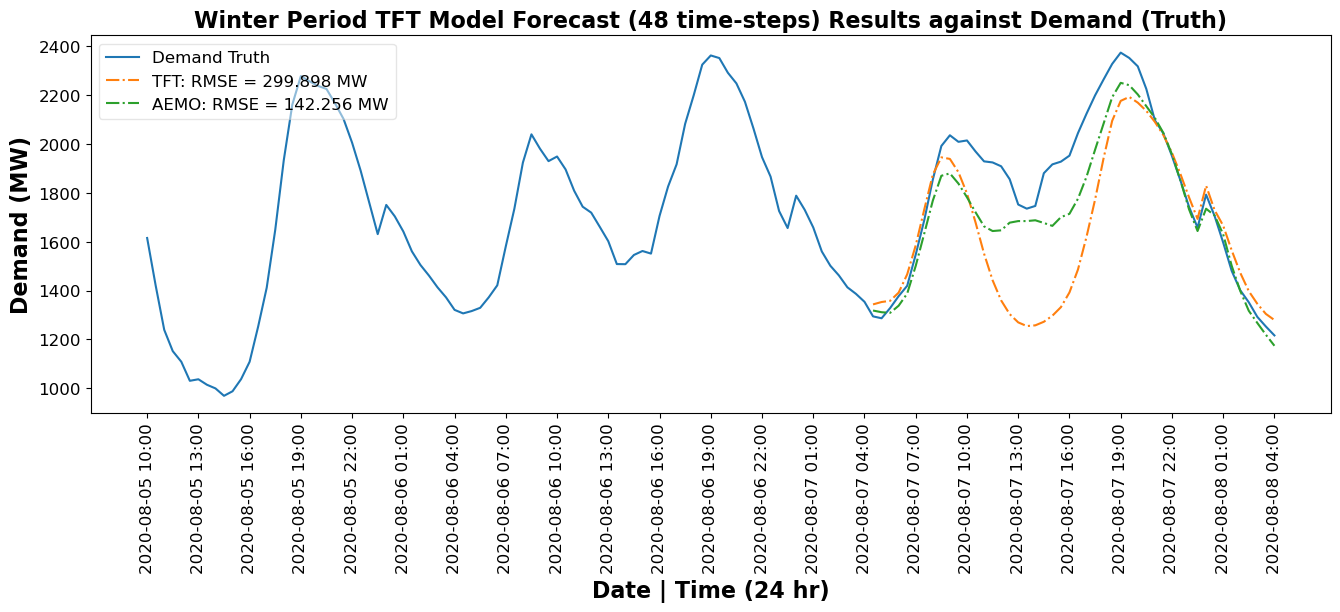

In [30]:
#LSTM Results

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_df['TIMEstrg'], truth_demand_df['TOTALDEMAND'], label='Demand Truth')
#plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['LSTM'], linestyle='-.', label='LSTM: RMSE = %.3f MW' % rmseLSTM_winter)
plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['TFT'], linestyle='-.', label='TFT: RMSE = %.3f MW' % rmseTFT_winter)
plt_plot.plot(aemo_forecast_subset_df['TIMEstrg'], aemo_forecast_subset_df['FORECASTDEMAND'], linestyle='-.', label='AEMO: RMSE = %.3f MW' % rmseAEMO_winter)

#plt.xticks(rotation='vertical')
plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::6])
plt_plot.set_xticklabels(xStrg[::6], rotation='vertical')
plt.title('Winter Period TFT Model Forecast (48 time-steps) Results against Demand (Truth)', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('WinterTFTResultsPlot.png', bbox_inches='tight')
plt.show()

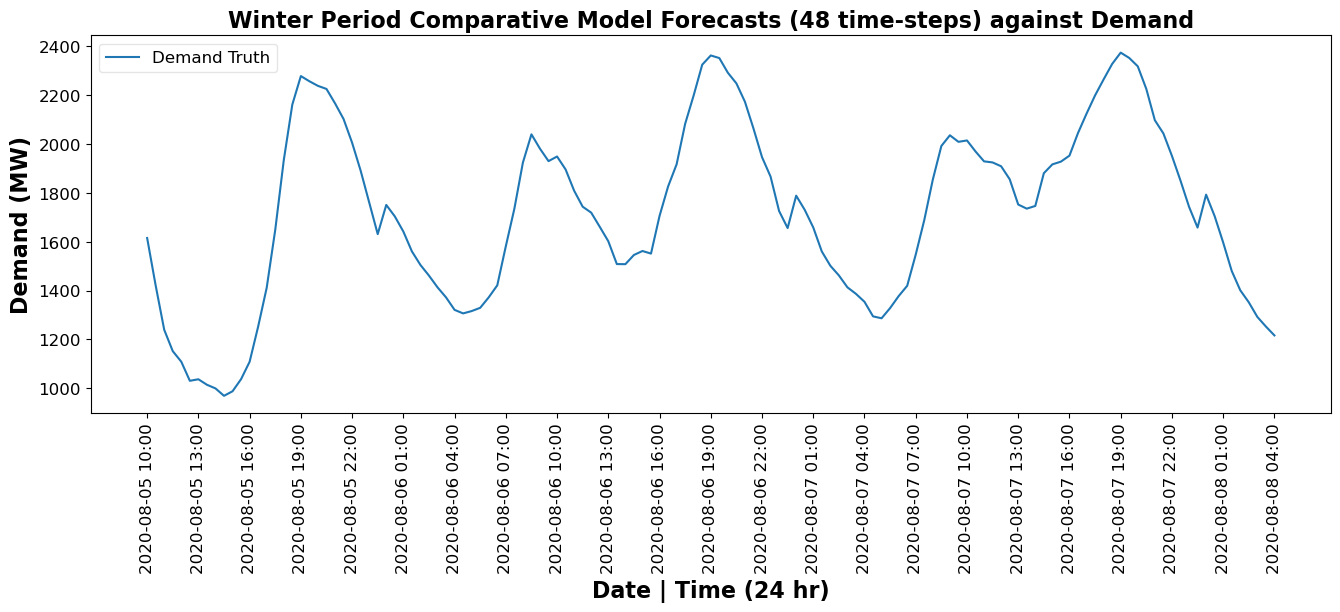

In [29]:
#Presentation Slide Plot: Winter 1

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_df['TIMEstrg'], truth_demand_df['TOTALDEMAND'], label='Demand Truth')
#plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['SARIMA'], linestyle='-.', label='SARIMA: RMSE = %.3f MW' % rmseARIMA_winter)
#plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['LSTM'], linestyle='-.', label='LSTM: RMSE = %.3f MW' % rmseLSTM_winter)
#plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['TFT'], linestyle='-.', label='TFT: RMSE = %.3f MW' % rmseTFT_winter)
#plt_plot.plot(aemo_forecast_subset_df['TIMEstrg'], aemo_forecast_subset_df['FORECASTDEMAND'], linestyle='-.', label='AEMO: RMSE = %.3f MW' % rmseAEMO_winter)

plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::6])
plt_plot.set_xticklabels(xStrg[::6], rotation='vertical')
plt.title('Winter Period Comparative Model Forecasts (48 time-steps) against Demand', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('WinterComparePlot1.png', bbox_inches='tight')
plt.show()

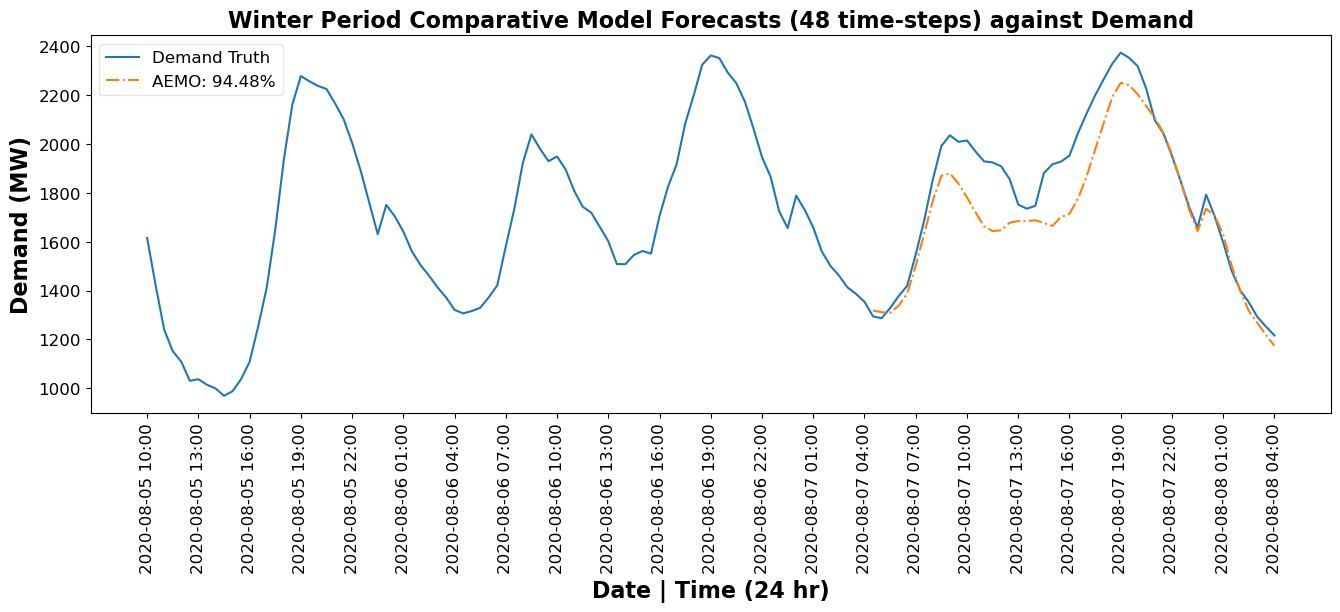

In [32]:
#Presentation Slide Plot: Winter 2

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_df['TIMEstrg'], truth_demand_df['TOTALDEMAND'], label='Demand Truth')
plt_plot.plot(aemo_forecast_subset_df['TIMEstrg'], aemo_forecast_subset_df['FORECASTDEMAND'], linestyle='-.', label='AEMO: %.2f' % AEMO_model_explained+'%')
#plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['SARIMA'], linestyle='-.', label='SARIMA: %.2f' % SARIMA_model_explained+'%')
#plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['LSTM'], linestyle='-.', label='LSTM: RMSE = %.3f MW' % rmseLSTM_winter)
#plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['TFT'], linestyle='-.', label='TFT: RMSE = %.3f MW' % rmseTFT_winter)
#plt_plot.plot(aemo_forecast_subset_df['TIMEstrg'], aemo_forecast_subset_df['FORECASTDEMAND'], linestyle='-.', label='AEMO: RMSE = %.3f MW' % rmseAEMO_winter)

plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::6])
plt_plot.set_xticklabels(xStrg[::6], rotation='vertical')
plt.title('Winter Period Comparative Model Forecasts (48 time-steps) against Demand', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('WinterComparePlot2.png', bbox_inches='tight')
plt.show()

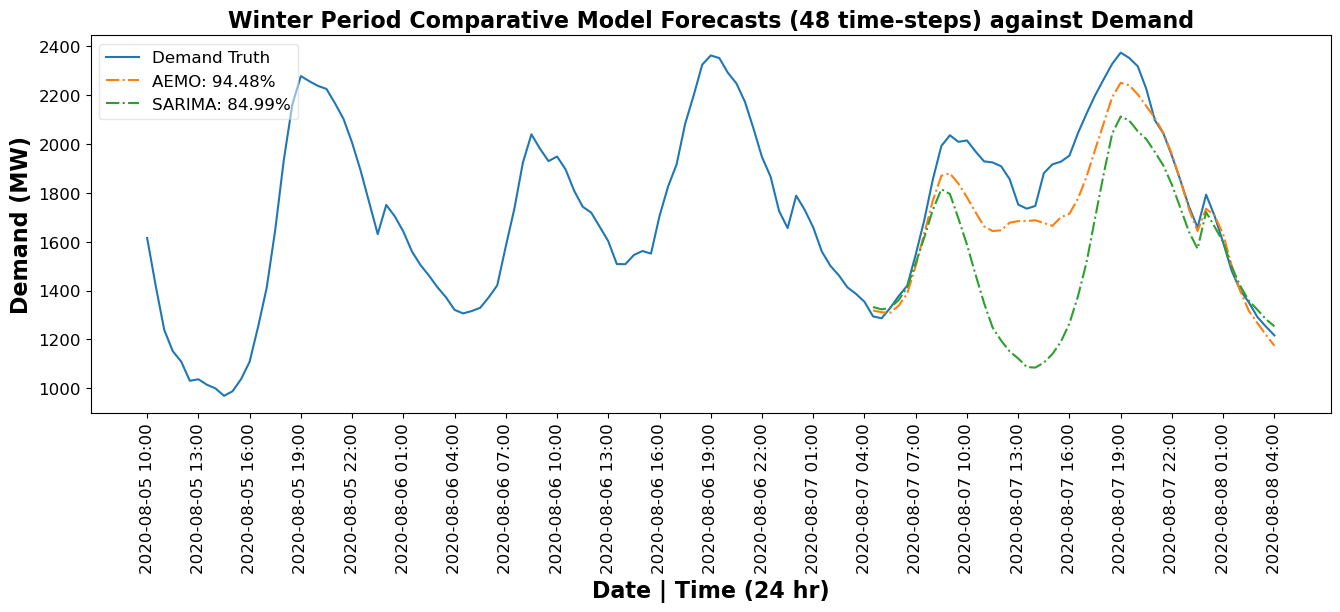

In [33]:
#Presentation Slide Plot: Winter 3

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_df['TIMEstrg'], truth_demand_df['TOTALDEMAND'], label='Demand Truth')
plt_plot.plot(aemo_forecast_subset_df['TIMEstrg'], aemo_forecast_subset_df['FORECASTDEMAND'], linestyle='-.', label='AEMO: %.2f' % AEMO_model_explained+'%')
plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['SARIMA'], linestyle='-.', label='SARIMA: %.2f' % SARIMA_model_explained+'%')
#plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['LSTM'], linestyle='-.', label='LSTM: RMSE = %.3f MW' % rmseLSTM_winter)
#plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['TFT'], linestyle='-.', label='TFT: RMSE = %.3f MW' % rmseTFT_winter)
#plt_plot.plot(aemo_forecast_subset_df['TIMEstrg'], aemo_forecast_subset_df['FORECASTDEMAND'], linestyle='-.', label='AEMO: RMSE = %.3f MW' % rmseAEMO_winter)

plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::6])
plt_plot.set_xticklabels(xStrg[::6], rotation='vertical')
plt.title('Winter Period Comparative Model Forecasts (48 time-steps) against Demand', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('WinterComparePlot3.png', bbox_inches='tight')
plt.show()

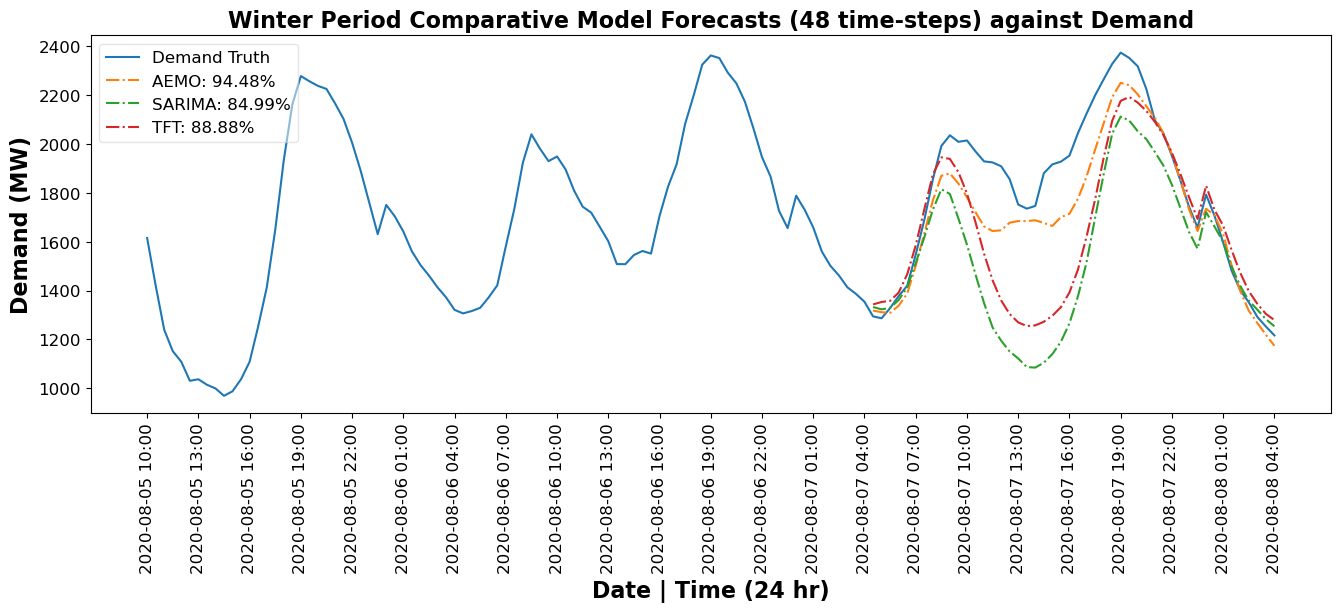

In [37]:
#Presentation Slide Plot: Winter 4

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_df['TIMEstrg'], truth_demand_df['TOTALDEMAND'], label='Demand Truth')
plt_plot.plot(aemo_forecast_subset_df['TIMEstrg'], aemo_forecast_subset_df['FORECASTDEMAND'], linestyle='-.', label='AEMO: %.2f' % AEMO_model_explained+'%')
plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['SARIMA'], linestyle='-.', label='SARIMA: %.2f' % SARIMA_model_explained+'%')
plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['TFT'], linestyle='-.', label='TFT: %.2f' % TFT_model_explained+'%')
#plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['LSTM'], linestyle='-.', label='LSTM: RMSE = %.3f MW' % rmseLSTM_winter)


plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::6])
plt_plot.set_xticklabels(xStrg[::6], rotation='vertical')
plt.title('Winter Period Comparative Model Forecasts (48 time-steps) against Demand', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('WinterComparePlot4.png', bbox_inches='tight')
plt.show()

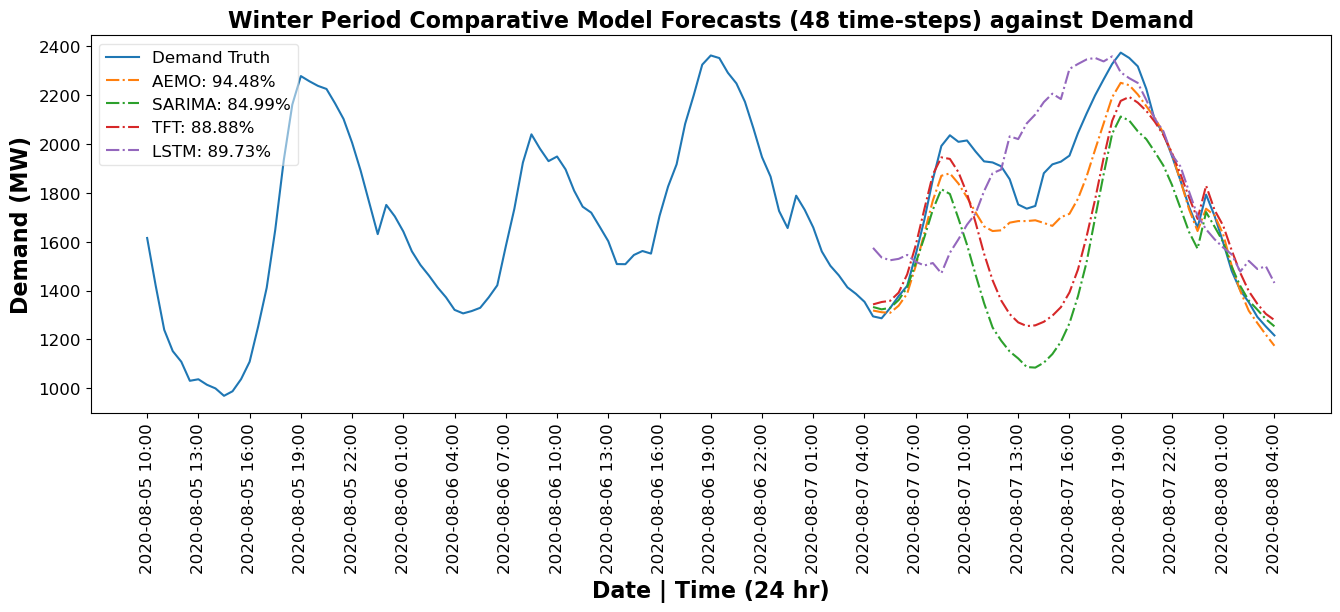

In [38]:
#Presentation Slide Plot: Winter 5

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_df['TIMEstrg'], truth_demand_df['TOTALDEMAND'], label='Demand Truth')
plt_plot.plot(aemo_forecast_subset_df['TIMEstrg'], aemo_forecast_subset_df['FORECASTDEMAND'], linestyle='-.', label='AEMO: %.2f' % AEMO_model_explained+'%')
plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['SARIMA'], linestyle='-.', label='SARIMA: %.2f' % SARIMA_model_explained+'%')
plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['TFT'], linestyle='-.', label='TFT: %.2f' % TFT_model_explained+'%')
plt_plot.plot(forecast_winter_df['TIMEstrg'], forecast_winter_df['LSTM'], linestyle='-.', label='LSTM: %.2f' % LSTM_model_explained+'%')


plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::6])
plt_plot.set_xticklabels(xStrg[::6], rotation='vertical')
plt.title('Winter Period Comparative Model Forecasts (48 time-steps) against Demand', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('WinterComparePlot5.png', bbox_inches='tight')
plt.show()

In [39]:
#Normal Forecast Plot

In [33]:
#Get 2021 data for model build
demand_sa_2021_df = demand_sa_df.loc[(demand_sa_df['YEAR'] == 2021)].reset_index()

#Get demand training data and forecast truth up to 18 March 00:00:00 2021 (inclusive)
iloc = (demand_sa_2021_df['DATETIME'] <= '2021-03-18 00:00:00')

#Create and capture normal demand 2021
demand_sa_normal_df = demand_sa_2021_df.loc[iloc]

In [34]:
#Subset summer training data
demand_sa_training_normal_df = demand_sa_normal_df.head(3600)

In [35]:
#Build final SARIMA model
model_normal = ARIMA(demand_sa_training_normal_df['TOTALDEMAND'], order=(3, 0, 0), seasonal_order=(1, 0, 1, 48))
model_normal_fit = model_normal.fit()

In [36]:
#Forecast 48 30min time steps
forecast_ARIMA_normal_48_ts = model_normal_fit.get_forecast(48, alpha=0.05).summary_frame()

In [37]:
#Capture 48 time steps of demand greater than forecast data
actual_demand_normal_2021_sa_48_ts_df = demand_sa_normal_df.tail(48)

#Generate time string for plotting
actual_demand_normal_2021_sa_48_ts_df['TIMEstrg'] = actual_demand_normal_2021_sa_48_ts_df['DATETIME'].dt.strftime('%Y-%m-%d %H:%M')

#Evaluate ARIMA normal demand 48 time steps forecasts
rmseARIMA_normal = sqrt(mean_squared_error(actual_demand_normal_2021_sa_48_ts_df['TOTALDEMAND'], forecast_ARIMA_normal_48_ts['mean'])) 
print('RMSE ARIMA Normal Demand Forecast (48 ts): %.3f MW' % rmseARIMA_normal)

RMSE ARIMA Normal Demand Forecast (48 ts): 96.637 MW


In [38]:
mapeSARIMA_normal = calc_mape(actual_demand_normal_2021_sa_48_ts_df['TOTALDEMAND'].values, forecast_ARIMA_normal_48_ts['mean'].values)
print('MAPE SARIMA Normal Demand Forecast (48 ts): %.4f' % mapeSARIMA_normal+'%')
SARIMA_model_explained = 100 - mapeSARIMA_normal
print('SARIMA Explained Normal Demand (48 ts): %.3f' % SARIMA_model_explained+'%')

MAPE SARIMA Normal Demand Forecast (48 ts): 7.7992%
SARIMA Explained Normal Demand (48 ts): 92.201%


In [39]:
##Evaluate AEMO normal demand 48 time steps forecasts

#Load AEMO forecast for 17.03.2021 0030 hrs to 18.03.2021 0000hrs
aemo_normal_forecast_df = pd.read_csv('aemo_2021_forecast.csv')

#Convert DATETIME string to type datetime and change format for plotting
aemo_normal_forecast_df['DATETIME'] = pd.to_datetime(aemo_normal_forecast_df['DATETIME'])
aemo_normal_forecast_df['TIMEstrg'] = aemo_normal_forecast_df['DATETIME'].dt.strftime('%Y-%m-%d %H:%M')

#Evaluate AEMO normal  48 time steps forecasts
rmseAEMO_normal = sqrt(mean_squared_error(actual_demand_normal_2021_sa_48_ts_df['TOTALDEMAND'], aemo_normal_forecast_df['FORECASTDEMAND'])) 
print('RMSE AEMO Normal Demand Forecast (48 ts): %.3f MW' % rmseAEMO_normal)

RMSE AEMO Normal Demand Forecast (48 ts): 82.658 MW


In [40]:
mapeAEMO_normal = calc_mape(actual_demand_normal_2021_sa_48_ts_df['TOTALDEMAND'].values, aemo_normal_forecast_df['FORECASTDEMAND'].values)
print('MAPE AEMO Normal Demand Forecast (48 ts): %.4f' % mapeAEMO_normal+'%')
AEMO_model_explained = 100 - mapeAEMO_normal
print('AEMO Explained Normal Demand (48 ts): %.3f' % AEMO_model_explained+'%')

MAPE AEMO Normal Demand Forecast (48 ts): 6.9866%
AEMO Explained Normal Demand (48 ts): 93.013%


In [41]:
#LSTM TFT forecasts
normal_forecast_df = pd.read_csv('normalForecasts.csv')

In [42]:
normal_forecast_df.head()

,DATETIME,TOTALDEMAND,LSTM,TFT
0,17/03/2021 0:30,1382.15,1449.0499,1352.686285
1,17/03/2021 1:00,1340.87,1401.9368,1329.046232
2,17/03/2021 1:30,1277.82,1379.1715,1267.002000
3,17/03/2021 2:00,1242.87,1344.9481,1175.818082
4,17/03/2021 2:30,1227.81,1334.9430,1214.473520


In [43]:
#Prepare demand forecast data for plotting

#Get actual demand from 11.03.2021 1230 hrs til final prediction forcast time 18.03.2021 0000 hrs
iloc = (demand_sa_normal_df['DATETIME'] >= '2021-03-14 12:00:00') & (demand_sa_normal_df['DATETIME'] <= '2021-03-18 00:00:00')
truth_demand_sa_normal_df = demand_sa_normal_df[iloc]
truth_demand_sa_normal_df['TIMEstrg'] = demand_sa_normal_df['DATETIME'].dt.strftime('%Y-%m-%d %H:%M')

#Get and prepare 48 time step forecast summer demand between 17.03.2021 0030 hrs and 18.03.2021 0000 hrs 
forecast_ARIMA_normal_series = forecast_ARIMA_normal_48_ts['mean'].reset_index(drop=True)
normal_time_series = actual_demand_normal_2021_sa_48_ts_df['DATETIME'].reset_index(drop=True)
normal_forecast_demand_time_df = pd.concat([forecast_ARIMA_normal_series, normal_time_series], axis=1).rename(columns={'mean': 'SARIMA', 'DATETIME': 'TIME'})
normal_forecast_demand_time_df['TIMEstrg'] = normal_forecast_demand_time_df['TIME'].dt.strftime('%Y-%m-%d %H:%M')

#Get and prepare 48 time step LSTM and TFT forecast demand between 17.03.2021 0030 hrs and 18.03.2021 0000 hrs
normal_forecast_demand_time_df = normal_forecast_demand_time_df.join(normal_forecast_df['TFT'])
normal_forecast_demand_time_df = normal_forecast_demand_time_df.join(normal_forecast_df['LSTM'])

#Add AEMO forecast to data set
aemo_normal_forecast_df.rename(columns = {'FORECASTDEMAND':'AEMO'}, inplace = True)
normal_forecast_demand_time_df = normal_forecast_demand_time_df.join(aemo_normal_forecast_df['AEMO'])


In [44]:
normal_forecast_demand_time_df.head()

,SARIMA,TIME,TIMEstrg,TFT,LSTM,AEMO
0,1366.155676,2021-03-17 00:30:00,2021-03-17 00:30,1352.686285,1449.0499,1362.00
1,1361.078081,2021-03-17 01:00:00,2021-03-17 01:00,1329.046232,1401.9368,1323.73
2,1319.869222,2021-03-17 01:30:00,2021-03-17 01:30,1267.002000,1379.1715,1260.79
3,1244.946283,2021-03-17 02:00:00,2021-03-17 02:00,1175.818082,1344.9481,1214.06
4,1194.972118,2021-03-17 02:30:00,2021-03-17 02:30,1214.473520,1334.9430,1185.19


In [45]:
#Evaluate LSTM normal demand 48 time steps forecasts
rmseLSTM_normal = sqrt(mean_squared_error(actual_demand_normal_2021_sa_48_ts_df['TOTALDEMAND'], normal_forecast_demand_time_df['LSTM'])) 
print('RMSE LSTM Normal Demand Forecast (48 ts): %.3f MW' % rmseLSTM_normal)

RMSE LSTM Normal Demand Forecast (48 ts): 738.046 MW


In [46]:
mapeLSTM_normal = calc_mape(actual_demand_normal_2021_sa_48_ts_df['TOTALDEMAND'].values, normal_forecast_demand_time_df['LSTM'].values)
print('MAPE LSTM Normal Demand Forecast (48 ts): %.4f' % mapeLSTM_normal+'%')
LSTM_model_explained = 100 - mapeLSTM_normal
print('LSTM Explained Normal Demand (48 ts): %.3f' % LSTM_model_explained+'%')

MAPE LSTM Normal Demand Forecast (48 ts): 65.0502%
LSTM Explained Normal Demand (48 ts): 34.950%


In [47]:
#Evaluate TFT normal demand 48 time steps forecasts
rmseTFT_normal = sqrt(mean_squared_error(actual_demand_normal_2021_sa_48_ts_df['TOTALDEMAND'], normal_forecast_demand_time_df['TFT'])) 
print('RMSE TFT Normal Demand Forecast (48 ts): %.3f MW' % rmseTFT_normal)

RMSE TFT Normal Demand Forecast (48 ts): 48.160 MW


In [48]:
mapeTFT_normal = calc_mape(actual_demand_normal_2021_sa_48_ts_df['TOTALDEMAND'].values, normal_forecast_demand_time_df['TFT'].values)
print('MAPE TFT Normal Demand Forecast (48 ts): %.4f' % mapeTFT_normal+'%')
TFT_model_explained = 100 - mapeTFT_normal
print('TFT Explained Normal Demand (48 ts): %.3f' % TFT_model_explained+'%')

MAPE TFT Normal Demand Forecast (48 ts): 4.0941%
TFT Explained Normal Demand (48 ts): 95.906%


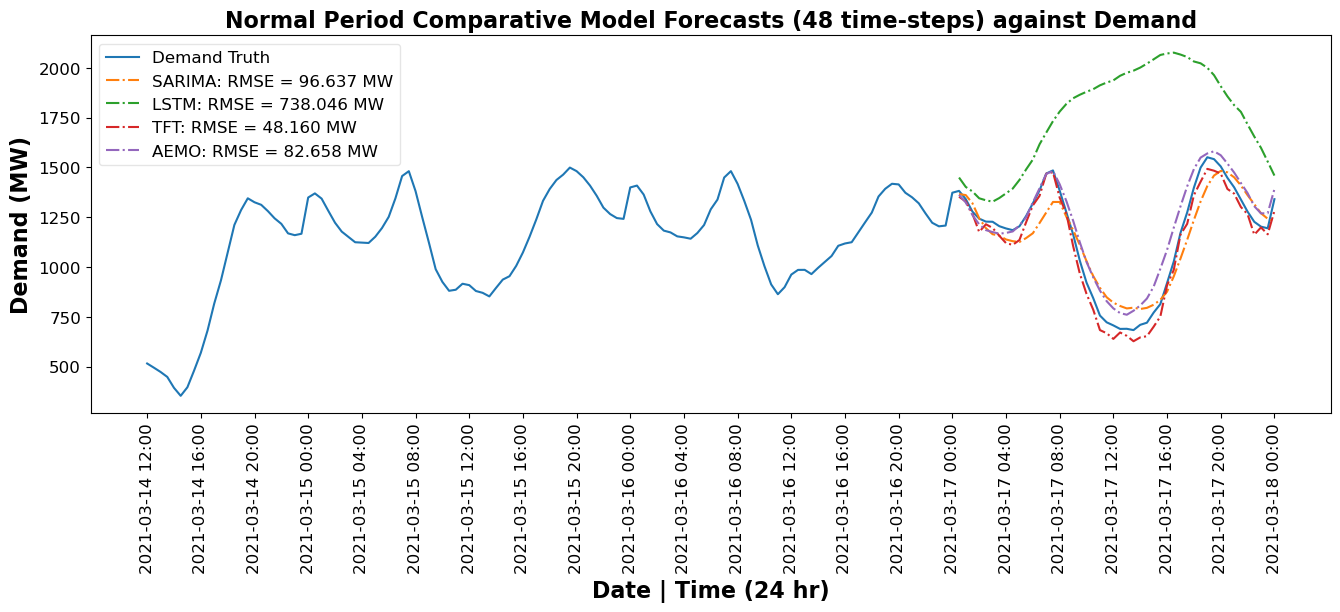

In [49]:
#Comparative demand forecast plot

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_sa_normal_df['TIMEstrg'], truth_demand_sa_normal_df['TOTALDEMAND'], label='Demand Truth')
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['SARIMA'], linestyle='-.', label='SARIMA: RMSE = %.3f MW' % rmseARIMA_normal)
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['LSTM'], linestyle='-.', label='LSTM: RMSE = %.3f MW' % rmseLSTM_normal)
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['TFT'], linestyle='-.', label='TFT: RMSE = %.3f MW' % rmseTFT_normal)
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['AEMO'], linestyle='-.', label='AEMO: RMSE = %.3f MW' % rmseAEMO_normal)

#plt.xticks(rotation='vertical')
plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_sa_normal_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::8])
plt_plot.set_xticklabels(xStrg[::8], rotation='vertical')
plt.title('Normal Period Comparative Model Forecasts (48 time-steps) against Demand', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('NormalComparePlot.png', bbox_inches='tight')
plt.show()

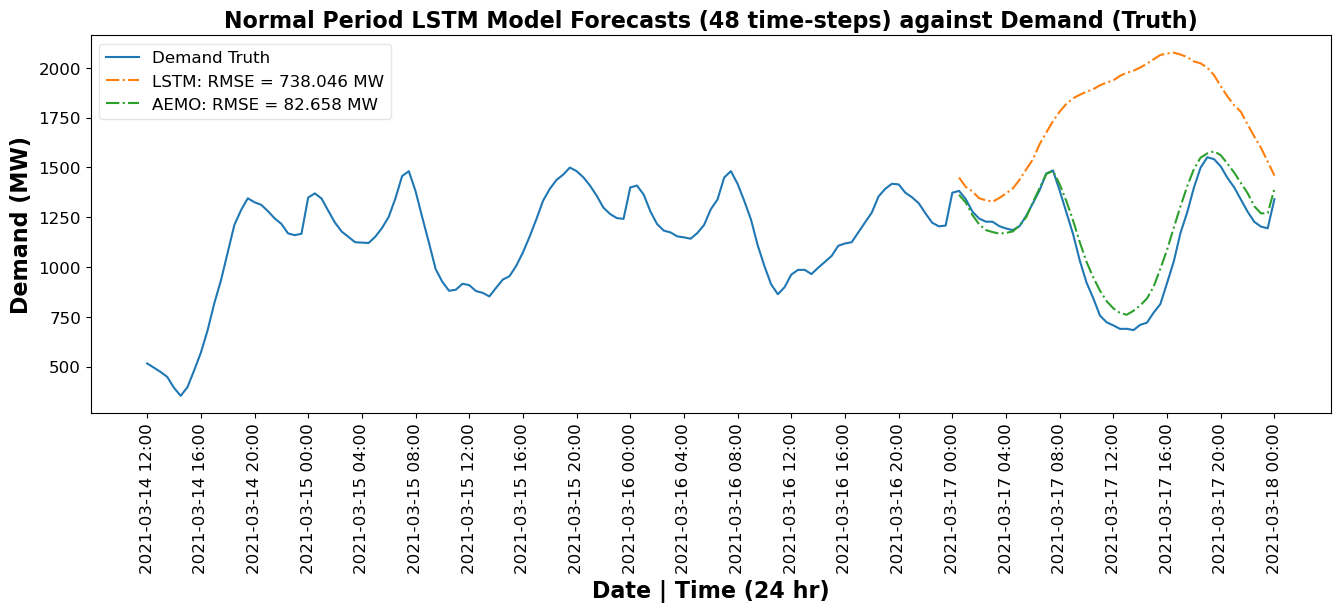

In [50]:
#Normal Period LSTM Model Results

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_sa_normal_df['TIMEstrg'], truth_demand_sa_normal_df['TOTALDEMAND'], label='Demand Truth')
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['LSTM'], linestyle='-.', label='LSTM: RMSE = %.3f MW' % rmseLSTM_normal)
#plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['TFT'], linestyle='-.', label='TFT: RMSE = %.3f MW' % rmseTFT_normal)
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['AEMO'], linestyle='-.', label='AEMO: RMSE = %.3f MW' % rmseAEMO_normal)

#plt.xticks(rotation='vertical')
plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_sa_normal_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::8])
plt_plot.set_xticklabels(xStrg[::8], rotation='vertical')
plt.title('Normal Period LSTM Model Forecasts (48 time-steps) against Demand (Truth)', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('NormalLSTMPlot.png', bbox_inches='tight')
plt.show()

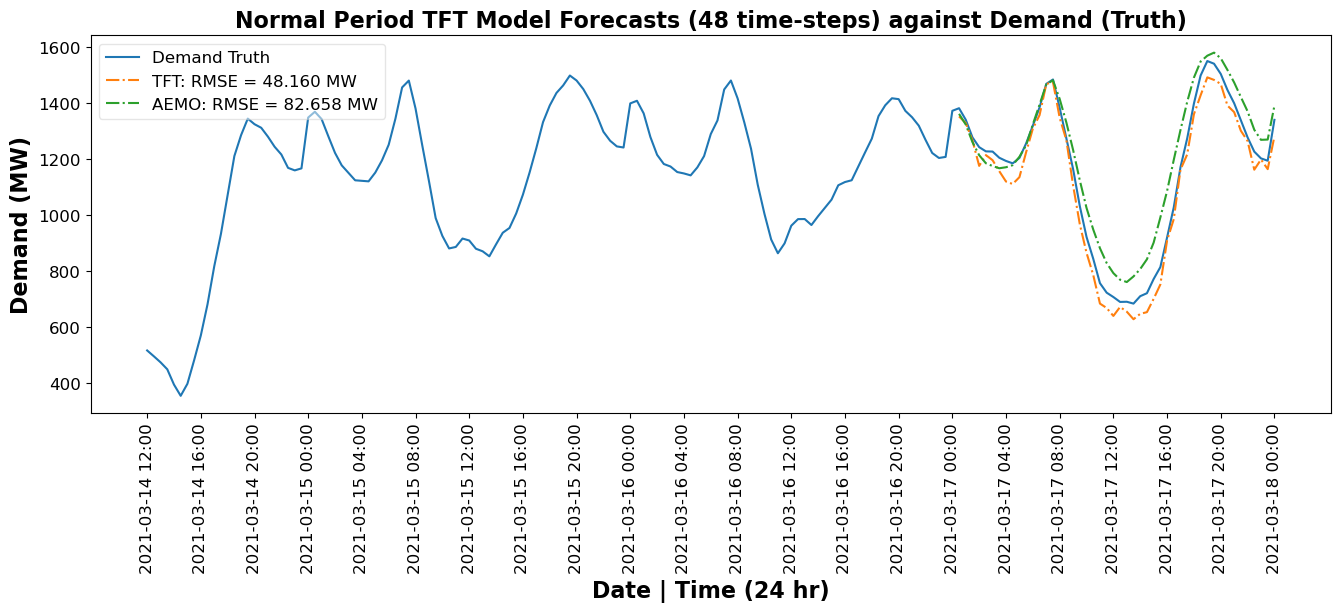

In [51]:
#Normal Period TFT Model Results

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_sa_normal_df['TIMEstrg'], truth_demand_sa_normal_df['TOTALDEMAND'], label='Demand Truth')
#plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['LSTM'], linestyle='-.', label='LSTM: RMSE = %.3f MW' % rmseLSTM_normal)
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['TFT'], linestyle='-.', label='TFT: RMSE = %.3f MW' % rmseTFT_normal)
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['AEMO'], linestyle='-.', label='AEMO: RMSE = %.3f MW' % rmseAEMO_normal)

#plt.xticks(rotation='vertical')
plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_sa_normal_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::8])
plt_plot.set_xticklabels(xStrg[::8], rotation='vertical')
plt.title('Normal Period TFT Model Forecasts (48 time-steps) against Demand (Truth)', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('NormalTFTPlot.png', bbox_inches='tight')
plt.show()

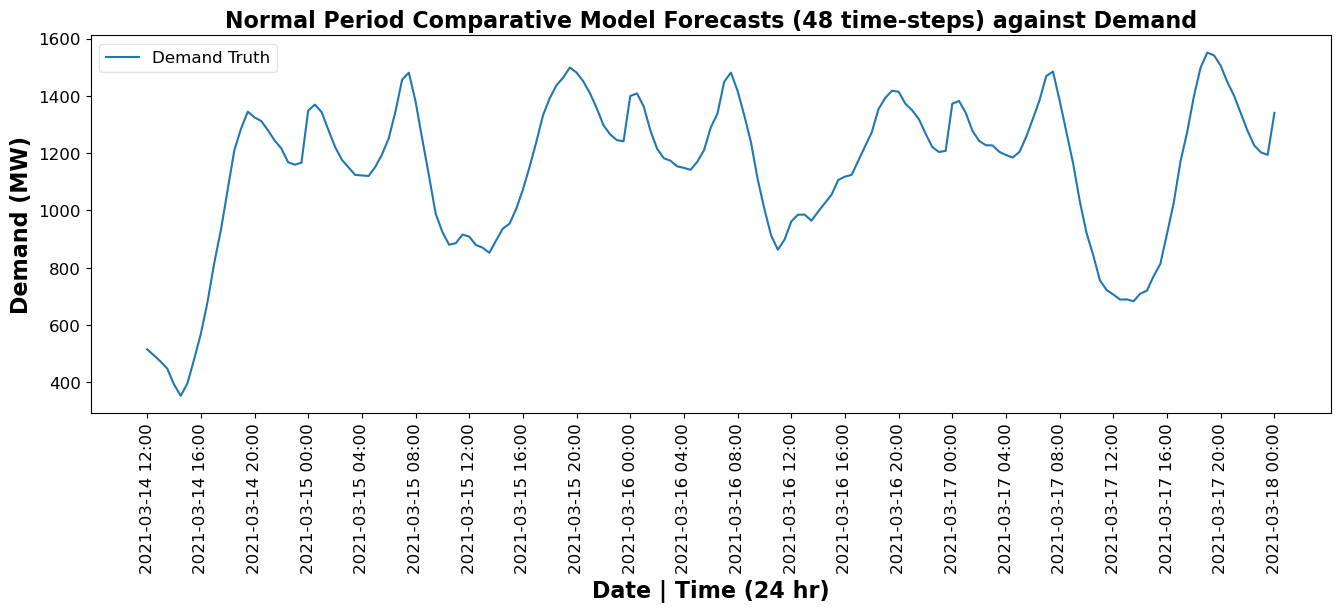

In [57]:
#Presentation Slide Plot: Normal 1

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_sa_normal_df['TIMEstrg'], truth_demand_sa_normal_df['TOTALDEMAND'], label='Demand Truth')
#plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['SARIMA'], linestyle='-.', label='SARIMA: RMSE = %.3f MW' % rmseARIMA_normal)
#plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['LSTM'], linestyle='-.', label='LSTM: RMSE = %.3f MW' % rmseLSTM_normal)
#plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['TFT'], linestyle='-.', label='TFT: RMSE = %.3f MW' % rmseTFT_normal)
#plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['AEMO'], linestyle='-.', label='AEMO: RMSE = %.3f MW' % rmseAEMO_normal)

#plt.xticks(rotation='vertical')
plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_sa_normal_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::8])
plt_plot.set_xticklabels(xStrg[::8], rotation='vertical')
plt.title('Normal Period Comparative Model Forecasts (48 time-steps) against Demand', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('NormalComparePlot1.png', bbox_inches='tight')
plt.show()

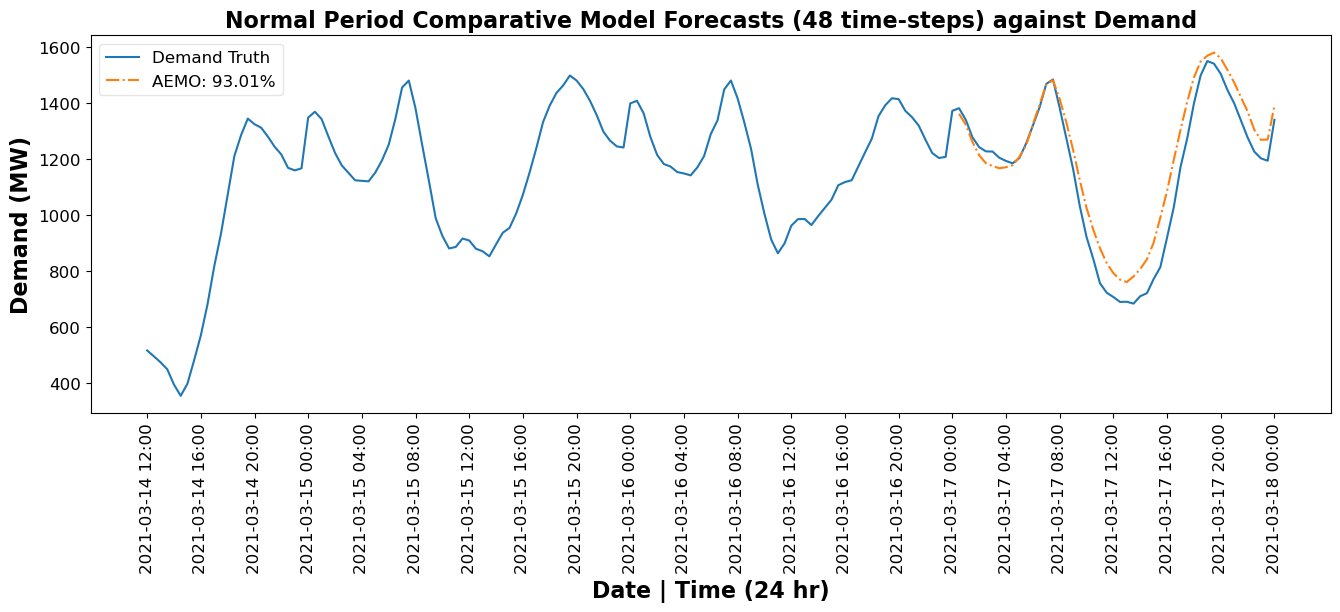

In [59]:
#Presentation Slide Plot: Normal 2

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_sa_normal_df['TIMEstrg'], truth_demand_sa_normal_df['TOTALDEMAND'], label='Demand Truth')
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['AEMO'], linestyle='-.', label='AEMO: %.2f' % AEMO_model_explained+'%')
#plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['LSTM'], linestyle='-.', label='LSTM: %.2f' % LSTM_model_explained+'%')
#plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['SARIMA'], linestyle='-.', label='SARIMA: RMSE = %.3f MW' % rmseARIMA_normal)
#plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['TFT'], linestyle='-.', label='TFT: RMSE = %.3f MW' % rmseTFT_normal)

#plt.xticks(rotation='vertical')
plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_sa_normal_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::8])
plt_plot.set_xticklabels(xStrg[::8], rotation='vertical')
plt.title('Normal Period Comparative Model Forecasts (48 time-steps) against Demand', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('NormalComparePlot2.png', bbox_inches='tight')
plt.show()

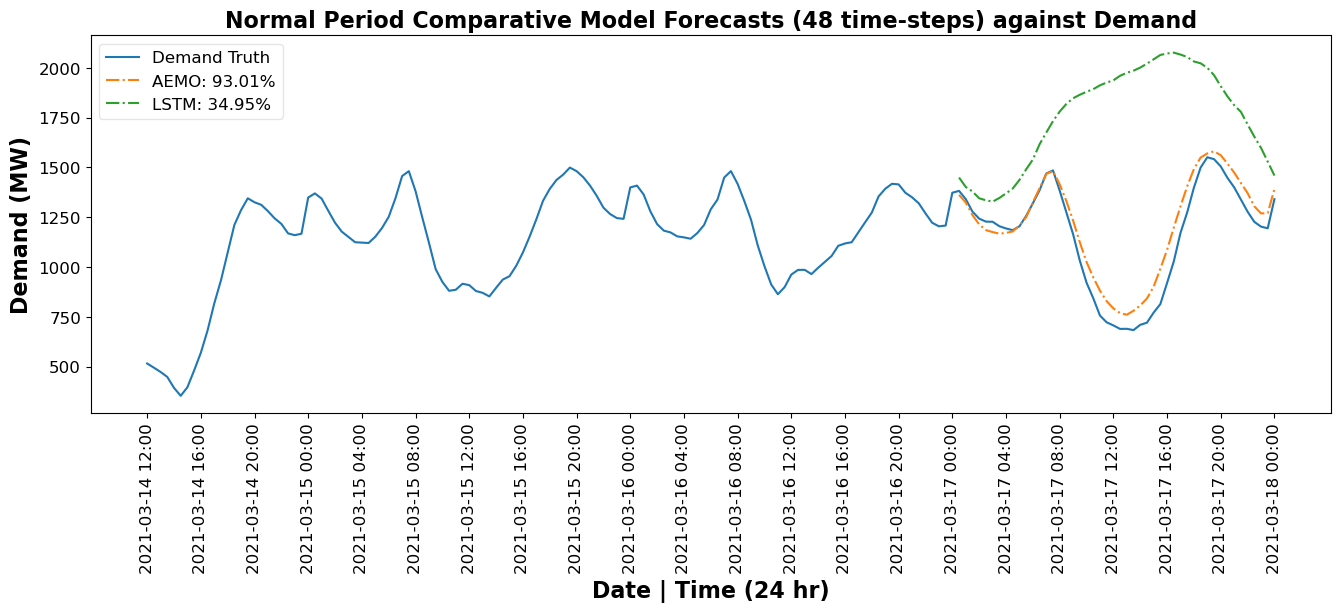

In [60]:
#Presentation Slide Plot: Normal 3

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_sa_normal_df['TIMEstrg'], truth_demand_sa_normal_df['TOTALDEMAND'], label='Demand Truth')
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['AEMO'], linestyle='-.', label='AEMO: %.2f' % AEMO_model_explained+'%')
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['LSTM'], linestyle='-.', label='LSTM: %.2f' % LSTM_model_explained+'%')
#plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['SARIMA'], linestyle='-.', label='SARIMA: RMSE = %.3f MW' % rmseARIMA_normal)
#plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['TFT'], linestyle='-.', label='TFT: RMSE = %.3f MW' % rmseTFT_normal)


#plt.xticks(rotation='vertical')
plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_sa_normal_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::8])
plt_plot.set_xticklabels(xStrg[::8], rotation='vertical')
plt.title('Normal Period Comparative Model Forecasts (48 time-steps) against Demand', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('NormalComparePlot3.png', bbox_inches='tight')
plt.show()

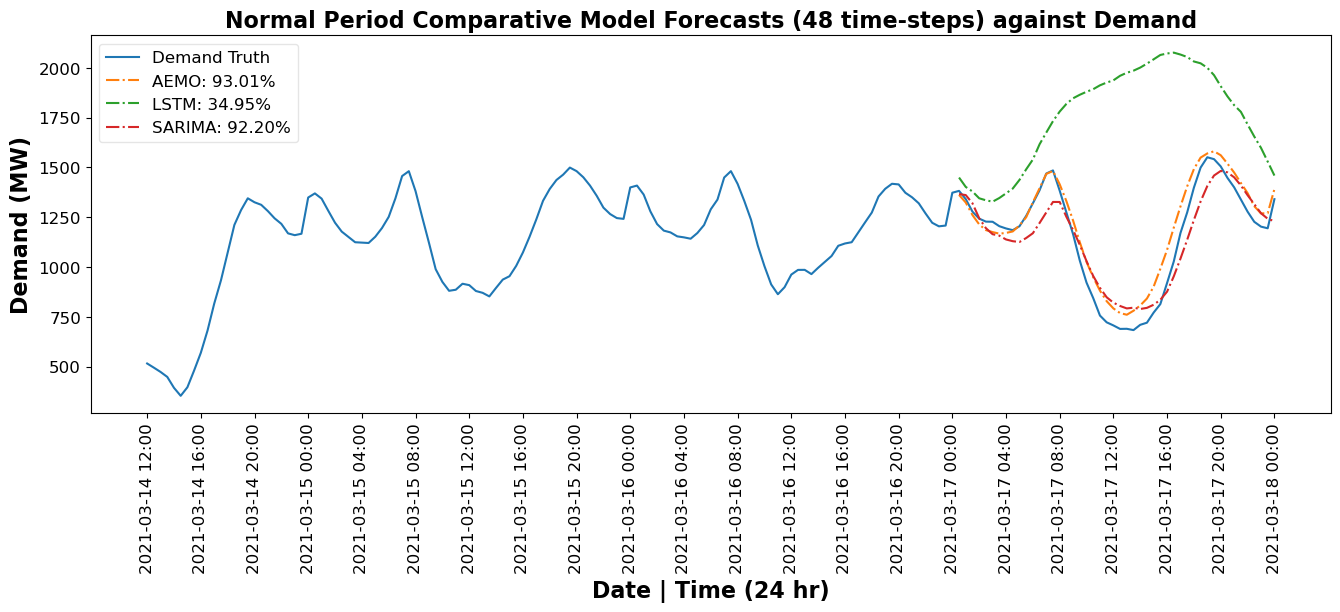

In [61]:
#Presentation Slide Plot: Normal 4

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_sa_normal_df['TIMEstrg'], truth_demand_sa_normal_df['TOTALDEMAND'], label='Demand Truth')
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['AEMO'], linestyle='-.', label='AEMO: %.2f' % AEMO_model_explained+'%')
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['LSTM'], linestyle='-.', label='LSTM: %.2f' % LSTM_model_explained+'%')
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['SARIMA'], linestyle='-.', label='SARIMA: %.2f' % SARIMA_model_explained+'%')
#plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['TFT'], linestyle='-.', label='TFT: RMSE = %.3f MW' % rmseTFT_normal)


#plt.xticks(rotation='vertical')
plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_sa_normal_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::8])
plt_plot.set_xticklabels(xStrg[::8], rotation='vertical')
plt.title('Normal Period Comparative Model Forecasts (48 time-steps) against Demand', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('NormalComparePlot4.png', bbox_inches='tight')
plt.show()

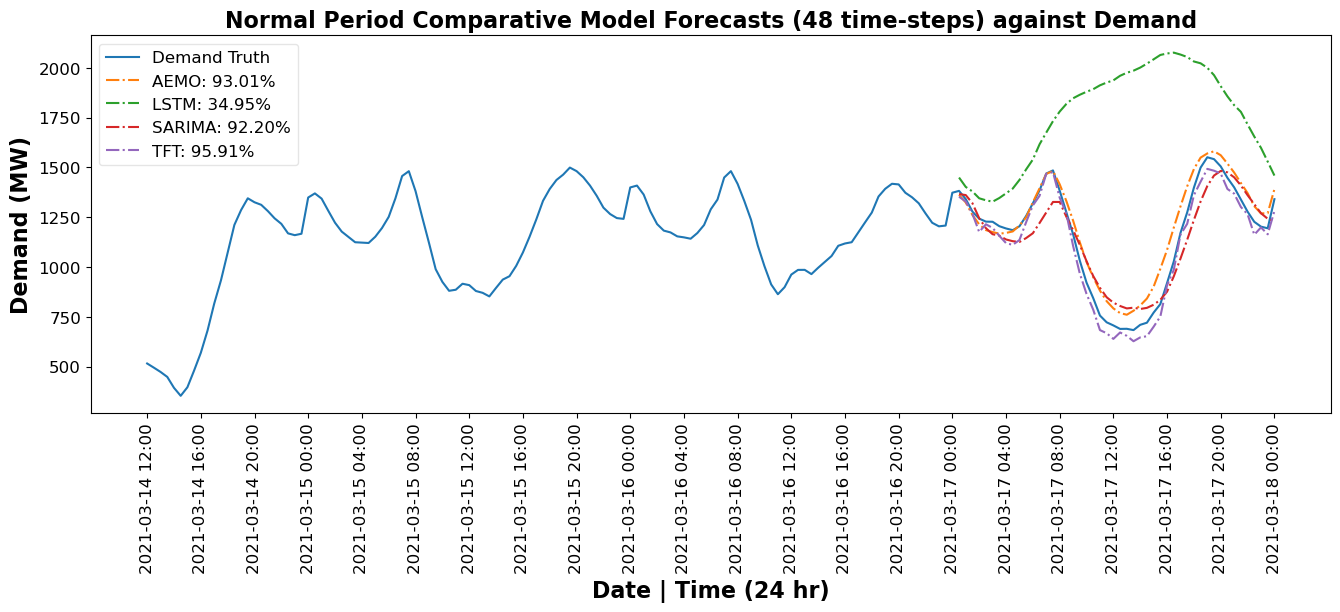

In [62]:
#Presentation Slide Plot: Normal 5

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_sa_normal_df['TIMEstrg'], truth_demand_sa_normal_df['TOTALDEMAND'], label='Demand Truth')
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['AEMO'], linestyle='-.', label='AEMO: %.2f' % AEMO_model_explained+'%')
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['LSTM'], linestyle='-.', label='LSTM: %.2f' % LSTM_model_explained+'%')
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['SARIMA'], linestyle='-.', label='SARIMA: %.2f' % SARIMA_model_explained+'%')
plt_plot.plot(normal_forecast_demand_time_df['TIMEstrg'], normal_forecast_demand_time_df['TFT'], linestyle='-.', label='TFT: %.2f' % TFT_model_explained+'%')

#plt.xticks(rotation='vertical')
plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_sa_normal_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::8])
plt_plot.set_xticklabels(xStrg[::8], rotation='vertical')
plt.title('Normal Period Comparative Model Forecasts (48 time-steps) against Demand', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('NormalComparePlot5.png', bbox_inches='tight')
plt.show()

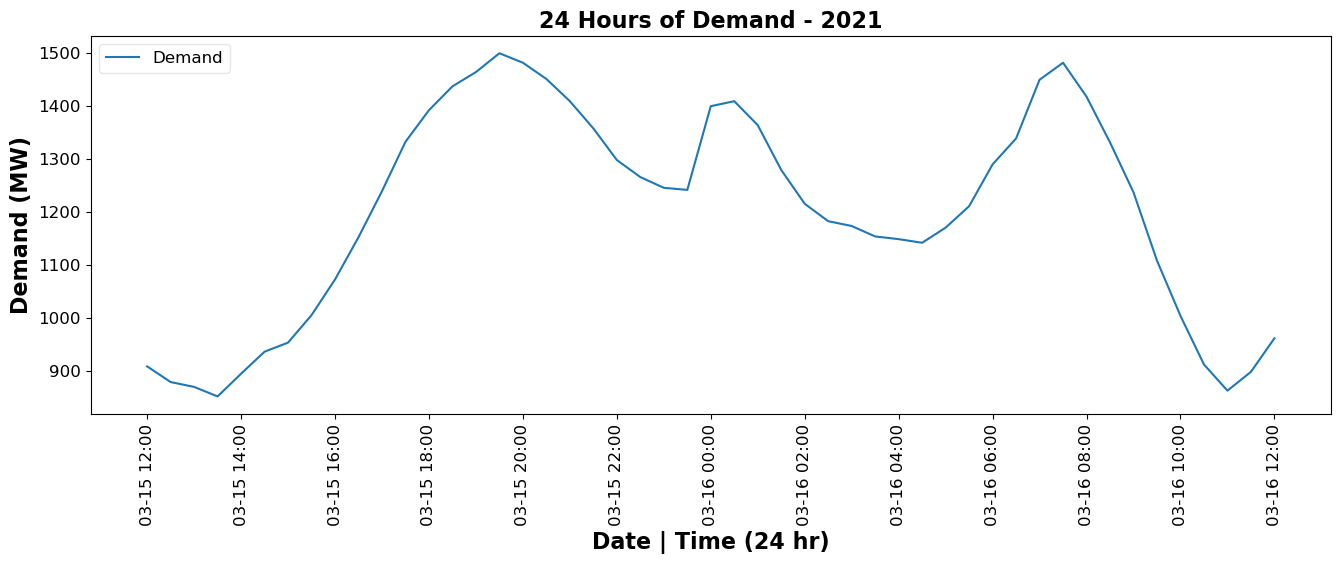

In [68]:
#Get 24 hr demand sample

iloc = (demand_sa_normal_df['DATETIME'] >= '2021-03-15 12:00:00') & (demand_sa_normal_df['DATETIME'] <= '2021-03-16 12:00:00')
truth_demand_sa_normal_df = demand_sa_normal_df[iloc]
truth_demand_sa_normal_df['TIMEstrg'] = demand_sa_normal_df['DATETIME'].dt.strftime('%m-%d %H:%M')

#Presentation Slide Plot: Normal 1

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_sa_normal_df['TIMEstrg'], truth_demand_sa_normal_df['TOTALDEMAND'], label='Demand')

#plt.xticks(rotation='vertical')
plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_sa_normal_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::4])
plt_plot.set_xticklabels(xStrg[::4], rotation='vertical')
plt.title('24 Hours of Demand - 2021', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)
plt.savefig('demand_24_hrs.png', bbox_inches='tight')
plt.show()

In [112]:
truth_demand_sa_normal_df.tail()

,index,DATETIME,TOTALDEMAND,REGIONID,YEAR,MONTH,TIMEstrg
3644,196507,2021-03-17 22:00:00,1277.91,SA1,2021,3,2021-03-17 22:00
3645,196508,2021-03-17 22:30:00,1226.81,SA1,2021,3,2021-03-17 22:30
3646,196509,2021-03-17 23:00:00,1202.62,SA1,2021,3,2021-03-17 23:00
3647,196510,2021-03-17 23:30:00,1194.34,SA1,2021,3,2021-03-17 23:30
3648,196511,2021-03-18 00:00:00,1340.58,SA1,2021,3,2021-03-18 00:00


In [3]:
demand_sa_df.shape

(196512, 3)

In [4]:
demand_sa_df.head(2)

,DATETIME,TOTALDEMAND,REGIONID
0,2010-01-01 00:30:00,1385.23,SA1
1,2010-01-01 01:00:00,1338.53,SA1


In [6]:
demand_sa_df.tail(2)

,DATETIME,TOTALDEMAND,REGIONID
196510,2021-03-17 23:30:00,1194.34,SA1
196511,2021-03-18 00:00:00,1340.58,SA1


In [3]:
#Convert DATETIME string to type datetime 
demand_sa_df['DATETIME'] = pd.to_datetime(demand_sa_df['DATETIME'])

#Break down Timestamp into new attributes
demand_sa_df['YEAR'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).year
demand_sa_df['MONTH'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).month

In [4]:
#Get winter 2019 data for model build
demand_sa_2019_df = demand_sa_df.loc[(demand_sa_df['YEAR'] == 2019)].reset_index()
demand_sa_winter_2019_df = demand_sa_2019_df.loc[(demand_sa_2019_df['MONTH'] == 6) | (demand_sa_2019_df['MONTH'] == 7) | (demand_sa_2019_df['MONTH'] == 8) ].reset_index()

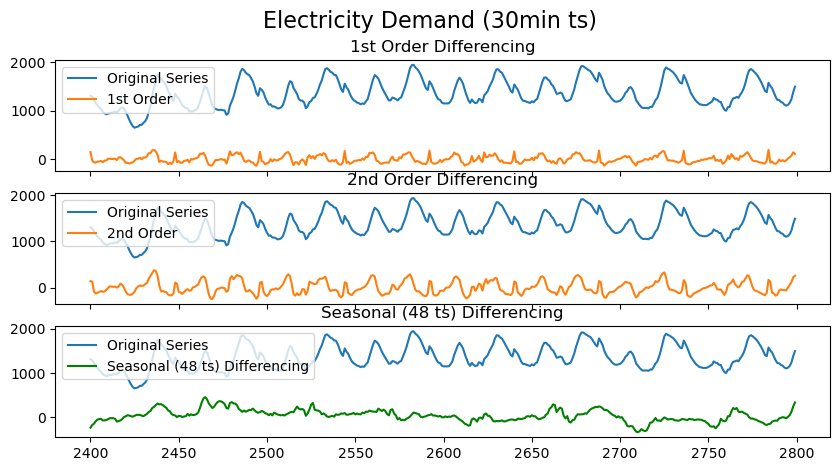

In [5]:
# Plot
fig, axes = plt.subplots(3, 1, figsize=(10,5), dpi=100, sharex=True)

# 1st Order Differencing
axes[0].plot(demand_sa_winter_2019_df['TOTALDEMAND'].iloc[2400:2800], label='Original Series')
axes[0].plot(demand_sa_winter_2019_df['TOTALDEMAND'].diff(1).iloc[2400:2800].dropna(), label='1st Order')
axes[0].set_title('1st Order Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# 2nd Order Differencing
axes[1].plot(demand_sa_winter_2019_df['TOTALDEMAND'].iloc[2400:2800], label='Original Series')
axes[1].plot(demand_sa_winter_2019_df['TOTALDEMAND'].diff(2).iloc[2400:2800].dropna(), label='2nd Order')
axes[1].set_title('2nd Order Differencing')
axes[1].legend(loc='upper left', fontsize=10)

# Seasonal Differencing (48 time steps (24hrs))
axes[2].plot(demand_sa_winter_2019_df['TOTALDEMAND'].iloc[2400:2800], label='Original Series')
axes[2].plot(demand_sa_winter_2019_df['TOTALDEMAND'].diff(48).iloc[2400:2800].dropna(), label='Seasonal (48 ts) Differencing', color='green')
axes[2].set_title('Seasonal (48 ts) Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Electricity Demand (30min ts)', fontsize=16)
plt.show()

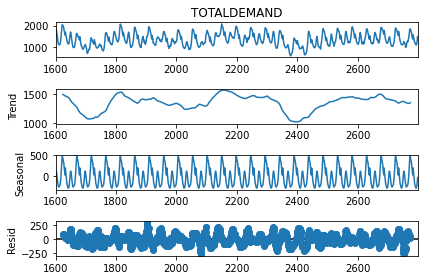

In [6]:
#Decompose time series (additive) across the whole data set
result_add = seasonal_decompose(demand_sa_winter_2019_df['TOTALDEMAND'].iloc[1600:2800], model='additive', period=48)
result_add.plot()
plt.show()

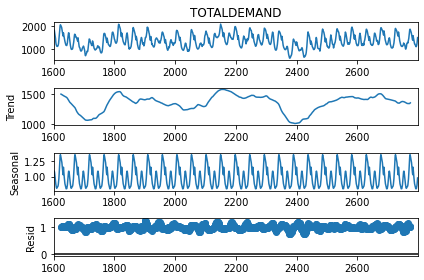

In [7]:
#Decompose time series (additive) across the whole data set
result_add = seasonal_decompose(demand_sa_winter_2019_df['TOTALDEMAND'].iloc[1600:2800], model='multiplicative', period=48)
result_add.plot()
plt.show()

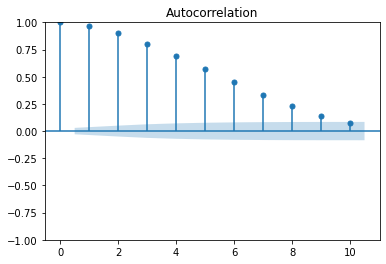

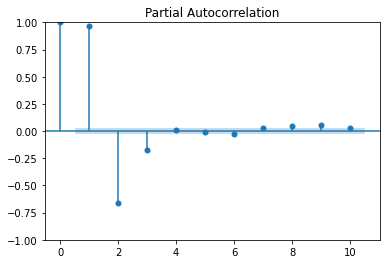

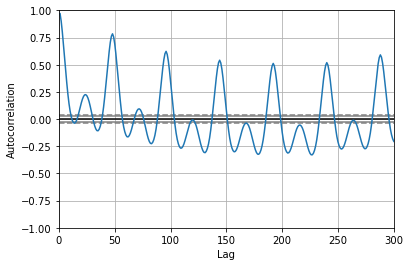

In [10]:
plot_acf(demand_sa_winter_2019_df['TOTALDEMAND'], lags=10, alpha=0.05)
plot_pacf(demand_sa_winter_2019_df['TOTALDEMAND'], lags=10, alpha=0.05)
plt.show()

autocorrelation_plot(demand_sa_winter_2019_df['TOTALDEMAND'])
plt.xlim([0, 300])
plt.show()

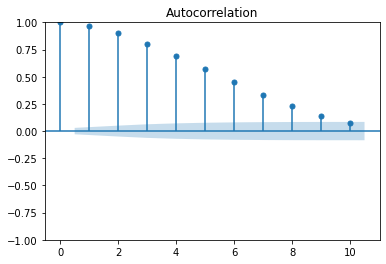

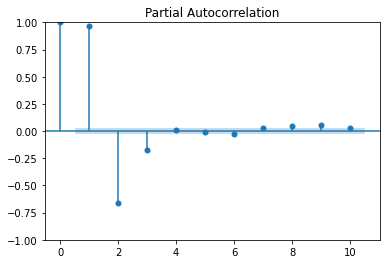

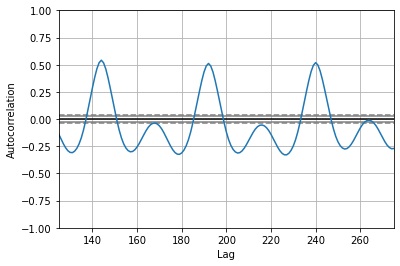

In [13]:
plot_acf(demand_sa_winter_2019_df['TOTALDEMAND'], lags=10, alpha=0.05)
plot_pacf(demand_sa_winter_2019_df['TOTALDEMAND'], lags=10, alpha=0.05)
plt.show()

autocorrelation_plot(demand_sa_winter_2019_df['TOTALDEMAND'])
plt.xlim([125, 275])
plt.show()

In [2]:
import darts

In [7]:
#SA Forecast demand
forecast_sa_df = pd.read_csv('forecastdemand_sa.csv')

In [8]:
forecast_sa_df.shape

(4095592, 6)

In [9]:
forecast_sa_df.head(2)

,PREDISPATCHSEQNO,REGIONID,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME
0,2016123018,SA1,71,1394.41,2016-12-30 12:31:25,2017-01-01 00:00:00
1,2016123018,SA1,72,1285.07,2016-12-30 12:31:25,2017-01-01 00:30:00


In [10]:
forecast_sa_df.tail(2)

,PREDISPATCHSEQNO,REGIONID,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME
4095590,2021031740,SA1,56,1194.31,2021-03-17 23:31:33,2021-03-19 03:30:00
4095591,2021031740,SA1,57,1190.41,2021-03-17 23:31:33,2021-03-19 04:00:00


In [12]:
#Get 48 time steps of actual demand to compare to forecast

iloc = (forecast_sa_df['LASTCHANGED'] == '2020-07-31 04:01:28') 
forecast_demand_2020_sa_df = forecast_sa_df.loc[iloc]

#Get 48 time steps demand forecast
forecast_demand_48_ts_2020_sa_df = forecast_demand_2020_sa_df.head(48)

In [14]:
forecast_demand_48_ts_2020_sa_df.head(4)

,PREDISPATCHSEQNO,REGIONID,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME
3483086,2020073101,SA1,1,1238.22,2020-07-31 04:01:28,2020-07-31 04:30:00
3483087,2020073101,SA1,2,1235.27,2020-07-31 04:01:28,2020-07-31 05:00:00
3483088,2020073101,SA1,3,1246.18,2020-07-31 04:01:28,2020-07-31 05:30:00
3483089,2020073101,SA1,4,1285.47,2020-07-31 04:01:28,2020-07-31 06:00:00


In [15]:
forecast_demand_48_ts_2020_sa_df.tail(4)

,PREDISPATCHSEQNO,REGIONID,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME
3484150,2020073101,SA1,45,1228.88,2020-07-31 04:01:28,2020-08-01 02:30:00
3484151,2020073101,SA1,46,1186.24,2020-07-31 04:01:28,2020-08-01 03:00:00
3484152,2020073101,SA1,47,1142.17,2020-07-31 04:01:28,2020-08-01 03:30:00
3484153,2020073101,SA1,48,1109.81,2020-07-31 04:01:28,2020-08-01 04:00:00


In [4]:
forecast_sa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4095592 entries, 0 to 4095591
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   PREDISPATCHSEQNO  int64  
 1   REGIONID          object 
 2   PERIODID          int64  
 3   FORECASTDEMAND    float64
 4   LASTCHANGED       object 
 5   DATETIME          object 
dtypes: float64(1), int64(2), object(3)
memory usage: 187.5+ MB


In [3]:
forecast_sa_df.head(100)

,PREDISPATCHSEQNO,REGIONID,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME
0,2016123018,SA1,71,1394.41,2016-12-30 12:31:25,2017-01-01 00:00:00
1,2016123018,SA1,72,1285.07,2016-12-30 12:31:25,2017-01-01 00:30:00
2,2016123018,SA1,73,1221.70,2016-12-30 12:31:25,2017-01-01 01:00:00
3,2016123018,SA1,74,1141.86,2016-12-30 12:31:25,2017-01-01 01:30:00
4,2016123018,SA1,75,1087.78,2016-12-30 12:31:25,2017-01-01 02:00:00
5,2016123018,SA1,76,1053.72,2016-12-30 12:31:25,2017-01-01 02:30:00
6,2016123018,SA1,77,1038.70,2016-12-30 12:31:25,2017-01-01 03:00:00
7,2016123018,SA1,78,1013.66,2016-12-30 12:31:25,2017-01-01 03:30:00
8,2016123018,SA1,79,992.61,2016-12-30 12:31:25,2017-01-01 04:00:00
9,2016123019,SA1,70,1387.78,2016-12-30 13:01:33,2017-01-01 00:00:00


In [4]:
forecast_sa_df.tail(100)

,PREDISPATCHSEQNO,REGIONID,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME
4095492,2021031739,SA1,16,1499.58,2021-03-17 23:01:36,2021-03-18 07:00:00
4095493,2021031739,SA1,17,1515.39,2021-03-17 23:01:36,2021-03-18 07:30:00
4095494,2021031739,SA1,18,1450.38,2021-03-17 23:01:36,2021-03-18 08:00:00
4095495,2021031739,SA1,19,1370.51,2021-03-17 23:01:36,2021-03-18 08:30:00
4095496,2021031739,SA1,20,1279.69,2021-03-17 23:01:36,2021-03-18 09:00:00
4095497,2021031739,SA1,21,1177.91,2021-03-17 23:01:36,2021-03-18 09:30:00
4095498,2021031739,SA1,22,1084.23,2021-03-17 23:01:36,2021-03-18 10:00:00
4095499,2021031739,SA1,23,1000.25,2021-03-17 23:01:36,2021-03-18 10:30:00
4095500,2021031739,SA1,24,935.82,2021-03-17 23:01:36,2021-03-18 11:00:00
4095501,2021031739,SA1,25,888.87,2021-03-17 23:01:36,2021-03-18 11:30:00


In [6]:
forecast_sa_df.tail(100)

,PREDISPATCHSEQNO,REGIONID,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME
4095492,2021031739,SA1,16,1499.58,2021-03-17 23:01:36,2021-03-18 07:00:00
4095493,2021031739,SA1,17,1515.39,2021-03-17 23:01:36,2021-03-18 07:30:00
4095494,2021031739,SA1,18,1450.38,2021-03-17 23:01:36,2021-03-18 08:00:00
4095495,2021031739,SA1,19,1370.51,2021-03-17 23:01:36,2021-03-18 08:30:00
4095496,2021031739,SA1,20,1279.69,2021-03-17 23:01:36,2021-03-18 09:00:00
4095497,2021031739,SA1,21,1177.91,2021-03-17 23:01:36,2021-03-18 09:30:00
4095498,2021031739,SA1,22,1084.23,2021-03-17 23:01:36,2021-03-18 10:00:00
4095499,2021031739,SA1,23,1000.25,2021-03-17 23:01:36,2021-03-18 10:30:00
4095500,2021031739,SA1,24,935.82,2021-03-17 23:01:36,2021-03-18 11:00:00
4095501,2021031739,SA1,25,888.87,2021-03-17 23:01:36,2021-03-18 11:30:00


In [7]:
#SA Temperature
temp_sa_df = pd.read_csv('temprature_sa.csv')

In [8]:
temp_sa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208085 entries, 0 to 208084
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   208085 non-null  int64  
 1   LOCATION     208085 non-null  object 
 2   DATETIME     208085 non-null  object 
 3   TEMPERATURE  208085 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.4+ MB


In [9]:
temp_sa_df.head(100)

,Unnamed: 0,LOCATION,DATETIME,TEMPERATURE
0,0,Adelaide (Kent Town),2010-01-01 00:00:00,23.6
1,1,Adelaide (Kent Town),2010-01-01 00:30:00,23.7
2,2,Adelaide (Kent Town),2010-01-01 01:00:00,23.5
3,3,Adelaide (Kent Town),2010-01-01 01:30:00,22.6
4,4,Adelaide (Kent Town),2010-01-01 02:00:00,22.0
5,5,Adelaide (Kent Town),2010-01-01 02:30:00,21.9
6,6,Adelaide (Kent Town),2010-01-01 03:00:00,22.0
7,7,Adelaide (Kent Town),2010-01-01 03:30:00,21.4
8,8,Adelaide (Kent Town),2010-01-01 04:00:00,21.5
9,9,Adelaide (Kent Town),2010-01-01 04:30:00,21.5


In [10]:
temp_sa_df.tail(100)

,Unnamed: 0,LOCATION,DATETIME,TEMPERATURE
207985,207985,Adelaide (Kent Town),2021-03-16 01:30:00,19.4
207986,207986,Adelaide (Kent Town),2021-03-16 02:00:00,19.5
207987,207987,Adelaide (Kent Town),2021-03-16 02:30:00,19.4
207988,207988,Adelaide (Kent Town),2021-03-16 03:00:00,19.4
207989,207989,Adelaide (Kent Town),2021-03-16 03:30:00,19.2
207990,207990,Adelaide (Kent Town),2021-03-16 04:00:00,19.1
207991,207991,Adelaide (Kent Town),2021-03-16 04:30:00,18.9
207992,207992,Adelaide (Kent Town),2021-03-16 05:00:00,18.9
207993,207993,Adelaide (Kent Town),2021-03-16 05:30:00,18.7
207994,207994,Adelaide (Kent Town),2021-03-16 06:00:00,18.7


In [3]:
#SA Demand
demand_sa_df = pd.read_csv('totaldemand_sa.csv')

In [10]:
demand_sa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196512 entries, 0 to 196511
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   DATETIME     196512 non-null  object 
 1   TOTALDEMAND  196512 non-null  float64
 2   REGIONID     196512 non-null  object 
dtypes: float64(1), object(2)
memory usage: 4.5+ MB


In [5]:
demand_sa_df.head(100)

,DATETIME,TOTALDEMAND,REGIONID
0,2010-01-01 00:30:00,1385.23,SA1
1,2010-01-01 01:00:00,1338.53,SA1
2,2010-01-01 01:30:00,1260.39,SA1
3,2010-01-01 02:00:00,1189.31,SA1
4,2010-01-01 02:30:00,1141.12,SA1
5,2010-01-01 03:00:00,1109.25,SA1
6,2010-01-01 03:30:00,1086.98,SA1
7,2010-01-01 04:00:00,1073.51,SA1
8,2010-01-01 04:30:00,1073.60,SA1
9,2010-01-01 05:00:00,1070.35,SA1


In [12]:
demand_sa_df.tail(100)

,DATETIME,TOTALDEMAND,REGIONID
196412,2021-03-15 22:30:00,1265.75,SA1
196413,2021-03-15 23:00:00,1245.56,SA1
196414,2021-03-15 23:30:00,1241.58,SA1
196415,2021-03-16 00:00:00,1399.40,SA1
196416,2021-03-16 00:30:00,1408.80,SA1
196417,2021-03-16 01:00:00,1363.62,SA1
196418,2021-03-16 01:30:00,1279.17,SA1
196419,2021-03-16 02:00:00,1215.42,SA1
196420,2021-03-16 02:30:00,1182.59,SA1
196421,2021-03-16 03:00:00,1173.56,SA1


In [4]:
demand_sa_df['YEAR'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).year
demand_sa_df['MONTH'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).month
demand_sa_df['DAY'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).day
demand_sa_df['TIME'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).time
demand_sa_df.head(4)

,DATETIME,TOTALDEMAND,REGIONID,YEAR,MONTH,DAY,TIME
0,2010-01-01 00:30:00,1385.23,SA1,2010,1,1,00:30:00
1,2010-01-01 01:00:00,1338.53,SA1,2010,1,1,01:00:00
2,2010-01-01 01:30:00,1260.39,SA1,2010,1,1,01:30:00
3,2010-01-01 02:00:00,1189.31,SA1,2010,1,1,02:00:00


In [5]:
demand_sa_2019_df = demand_sa_df.loc[demand_sa_df['YEAR'] == 2019].reset_index()

In [19]:
#Augmented Dickey-Fuller test for (non)stationary
ad_fuller_result = adfuller(demand_sa_2019_df['TOTALDEMAND'], autolag='AIC')
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'Number of lags: {ad_fuller_result[1]}')
print(f'p-value: {ad_fuller_result[1]}')
for key, value in ad_fuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -4.4443221853516786
Number of lags: 0.0002475737462646812
p-value: 0.0002475737462646812
Critial Values:
   1%, -3.4307242638530675
Critial Values:
   5%, -2.861705410152796
Critial Values:
   10%, -2.5668580435332715


In [20]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(demand_sa_2019_df['TOTALDEMAND']) #Test stationary around the mean
print('\n')
kpss_test(demand_sa_2019_df['TOTALDEMAND'], regression='ct') #Test stationary around a trend

KPSS Statistic: 1.583699226941686
p-value: 0.01
num lags: 72
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


KPSS Statistic: 0.3407323259713614
p-value: 0.01
num lags: 71
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Result: The series is not stationary


In [ ]:
#Data set is weak stationary

#A major difference between KPSS and ADF tests is the capability of the KPSS test to check for stationarity 
#in the ‘presence of a deterministic trend’.
#https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/
#https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

#https://www.statsmodels.org/devel/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

#KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. 
#Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

In [21]:
#Detrending by differencing
demand_sa_2019_df['TOTALDEMAND_diff_1'] = demand_sa_2019_df['TOTALDEMAND'] - demand_sa_2019_df['TOTALDEMAND'].shift(1)

In [22]:
#Repeat kpss test
kpss_test(demand_sa_2019_df['TOTALDEMAND_diff_1'].dropna()) #Test stationary around the mean
print('\n')
kpss_test(demand_sa_2019_df['TOTALDEMAND_diff_1'].dropna(), regression='ct') #Test stationary around a trend

KPSS Statistic: 0.0006507132041775075
p-value: 0.1
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


KPSS Statistic: 0.0006186050766200751
p-value: 0.1
num lags: 15
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Result: The series is stationary


In [23]:
#If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. 
#On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

#In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard
#deviation in the differenced series.

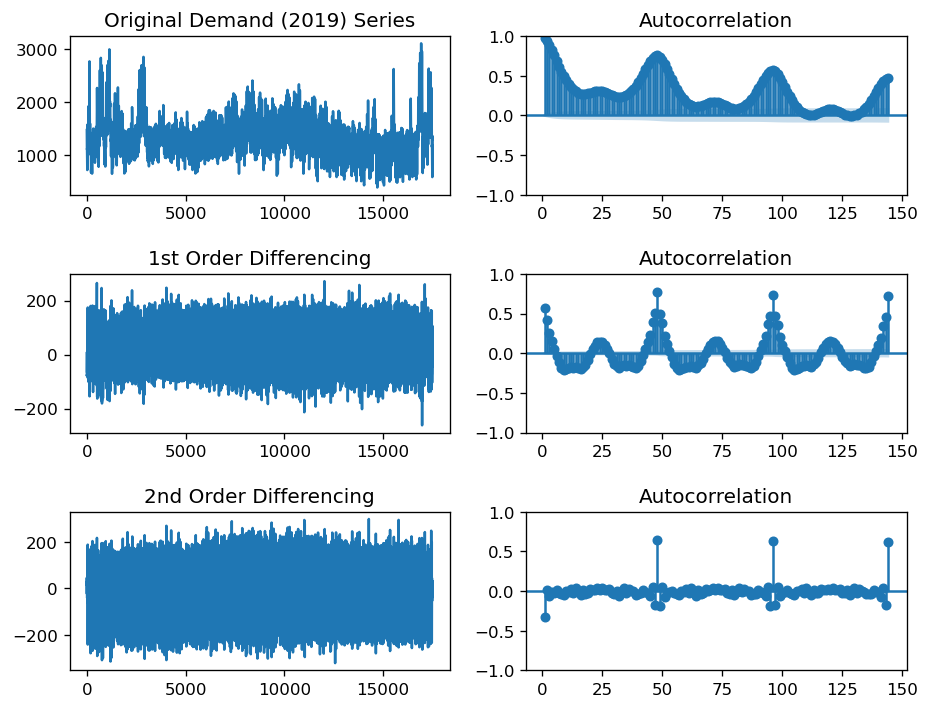

In [78]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
demand_series = demand_sa_2019_df['TOTALDEMAND']

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(demand_series); axes[0, 0].set_title('Original Demand (2019) Series')
plot_acf(demand_series, lags=144, zero=False, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(demand_series.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(demand_series.diff().dropna(), lags=144, zero=False, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(demand_series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(demand_series.diff().diff().dropna(), lags=144, zero=False, ax=axes[2, 1])

plt.subplots_adjust(hspace=0.5)

plt.show()

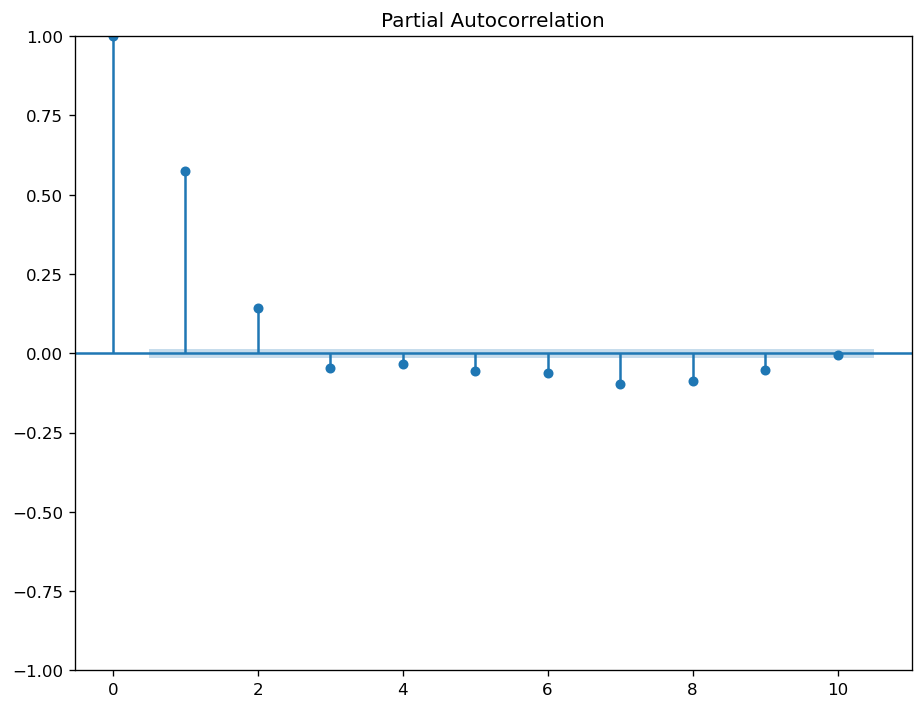

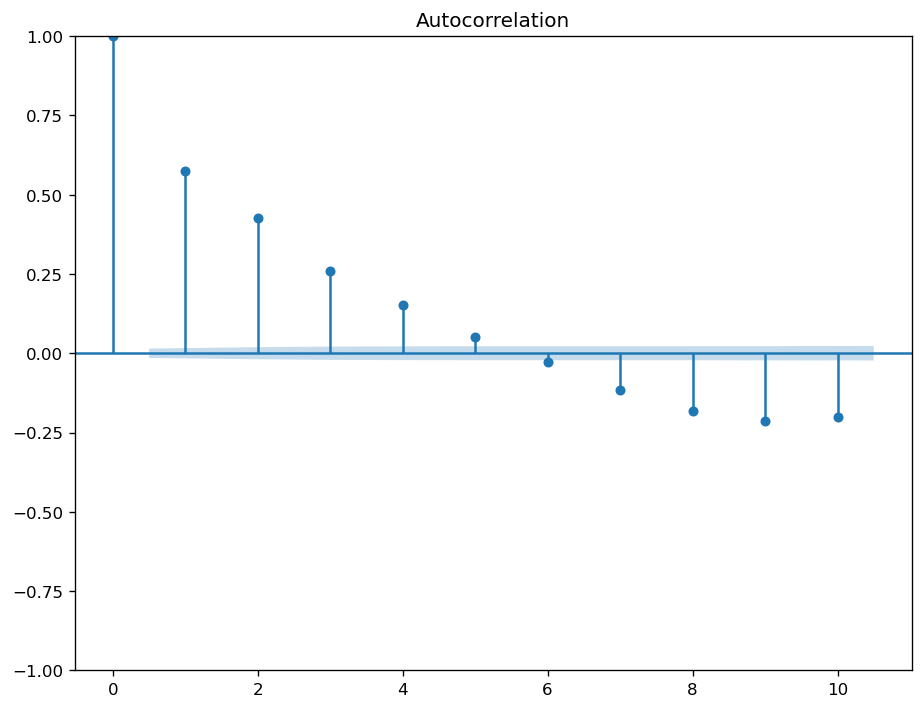

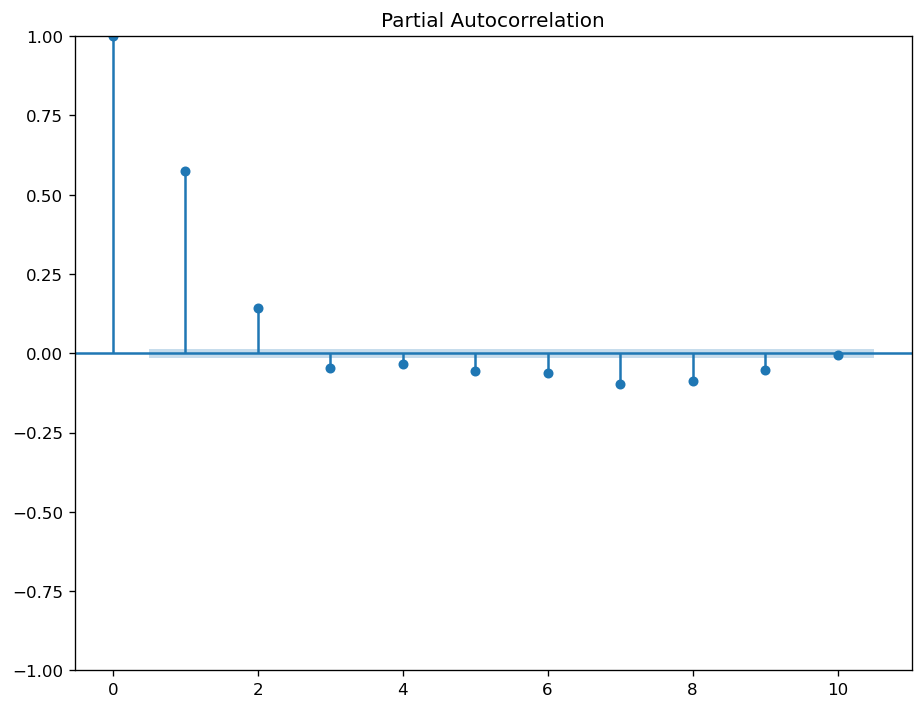

In [81]:
plot_acf(demand_series.diff().dropna(), lags=10, alpha=0.05)
plot_pacf(demand_series.diff().dropna(), lags=10, alpha=0.05)

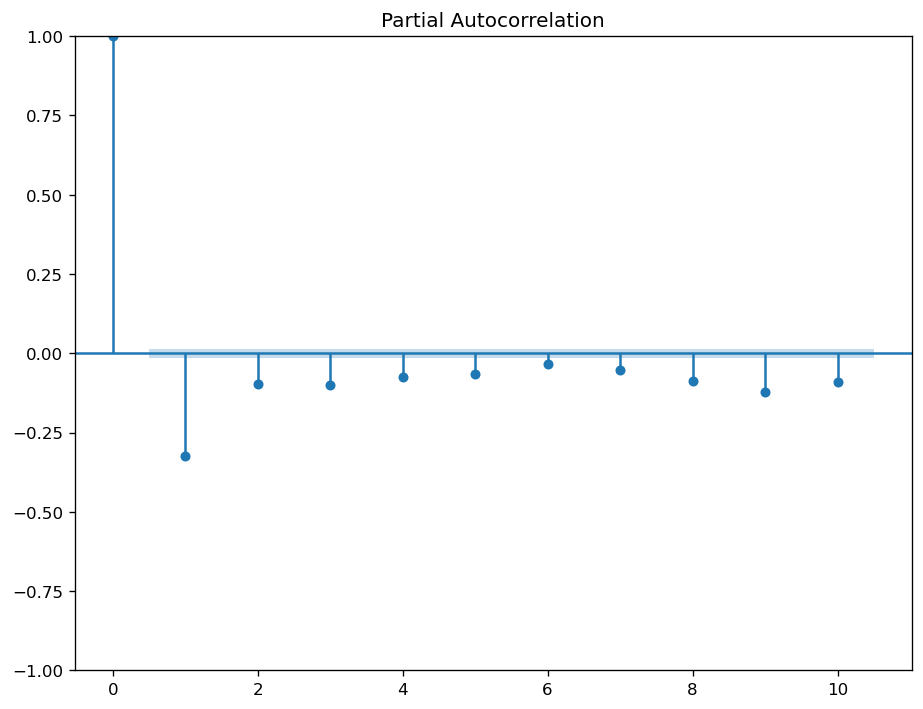

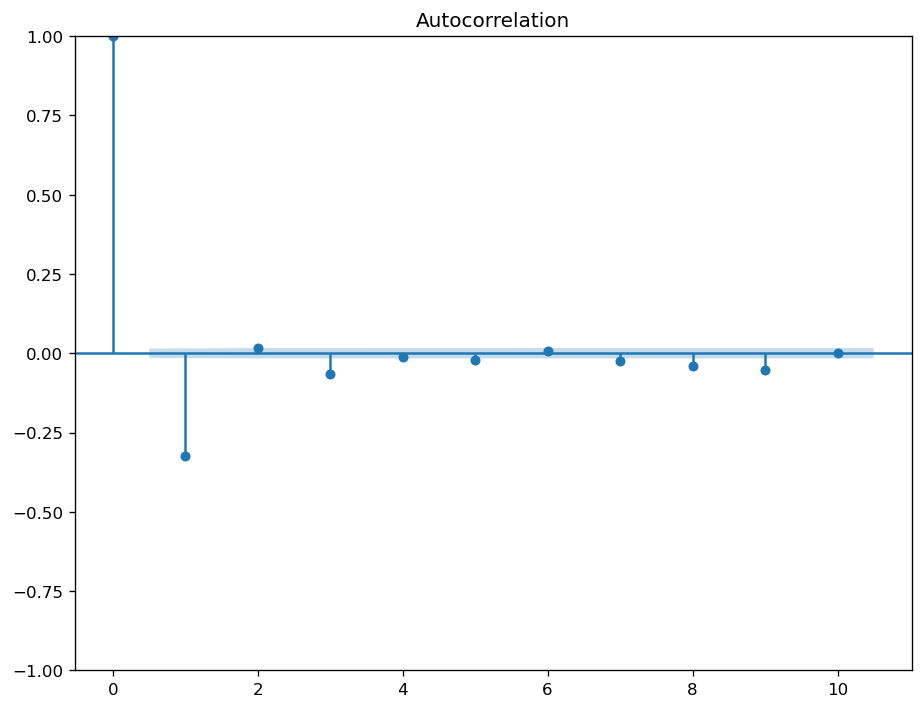

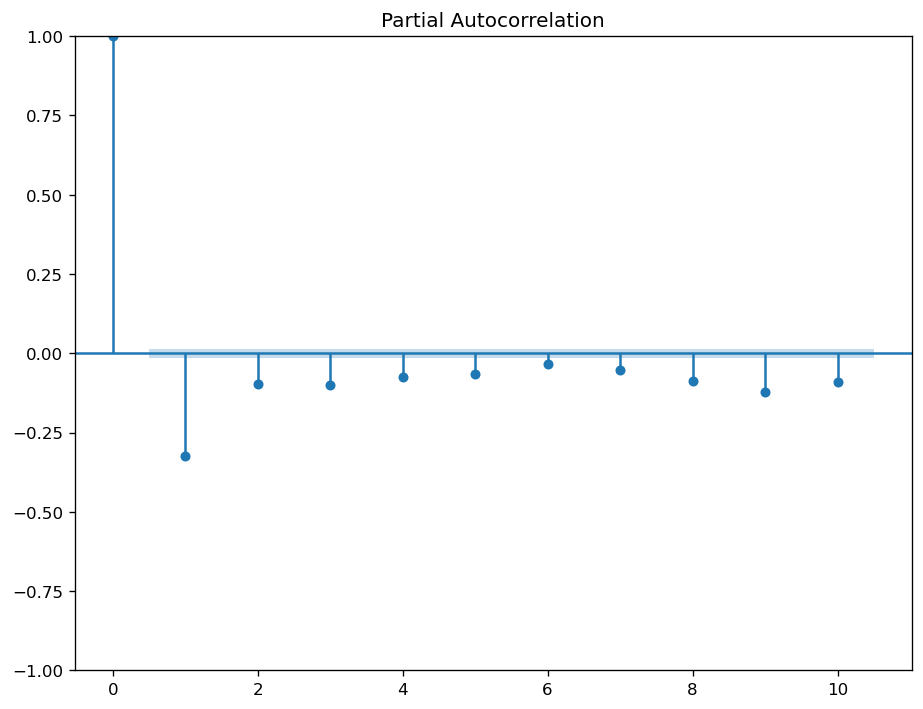

In [82]:
plot_acf(demand_series.diff().diff().dropna(), lags=10, alpha=0.05)
plot_pacf(demand_series.diff().diff().dropna(), lags=10, alpha=0.05)

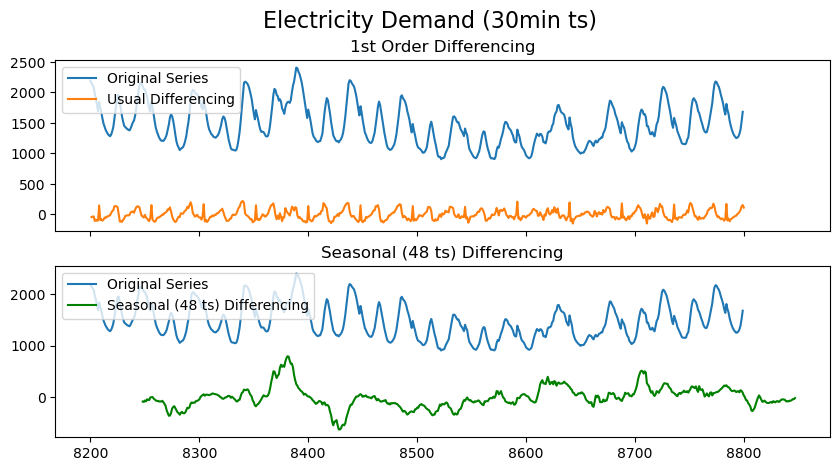

In [91]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(demand_series.iloc[8200:8800], label='Original Series')
axes[0].plot(demand_series.diff(1).dropna().iloc[8200:8800], label='1st Order Differencing')
axes[0].set_title('1st Order Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(demand_series.iloc[8200:8800], label='Original Series')
axes[1].plot(demand_series.diff(48).dropna().iloc[8200:8800], label='Seasonal (48 ts) Differencing', color='green')
axes[1].set_title('Seasonal (48 ts) Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Electricity Demand (30min ts)', fontsize=16)
plt.show()

In [64]:
#Fix differencing at 1

#Partial autocorrection plot demonstrates lag after which most lags are not significant, p=3
#Order of Integration I(d) represents the number of differences d=1 required to make the series stationary, d=1
#Moving average model MA(q), biggest lag after which other lags are not significant, q=5

#Seasonality S(P,D,Q,s)
#Seasonal length s=48
#D Order of seasonal integration representing the number of differences to remove seasonalit and any non-stationary behaviours (2?).

#large, high resolution time series. Due to the nature of how the ACF and PACF confidence limits are calculated in statsmodels1
#such a large time series will result in incredibly small values, resulting in the confidence intervals being basically 
#invisible.

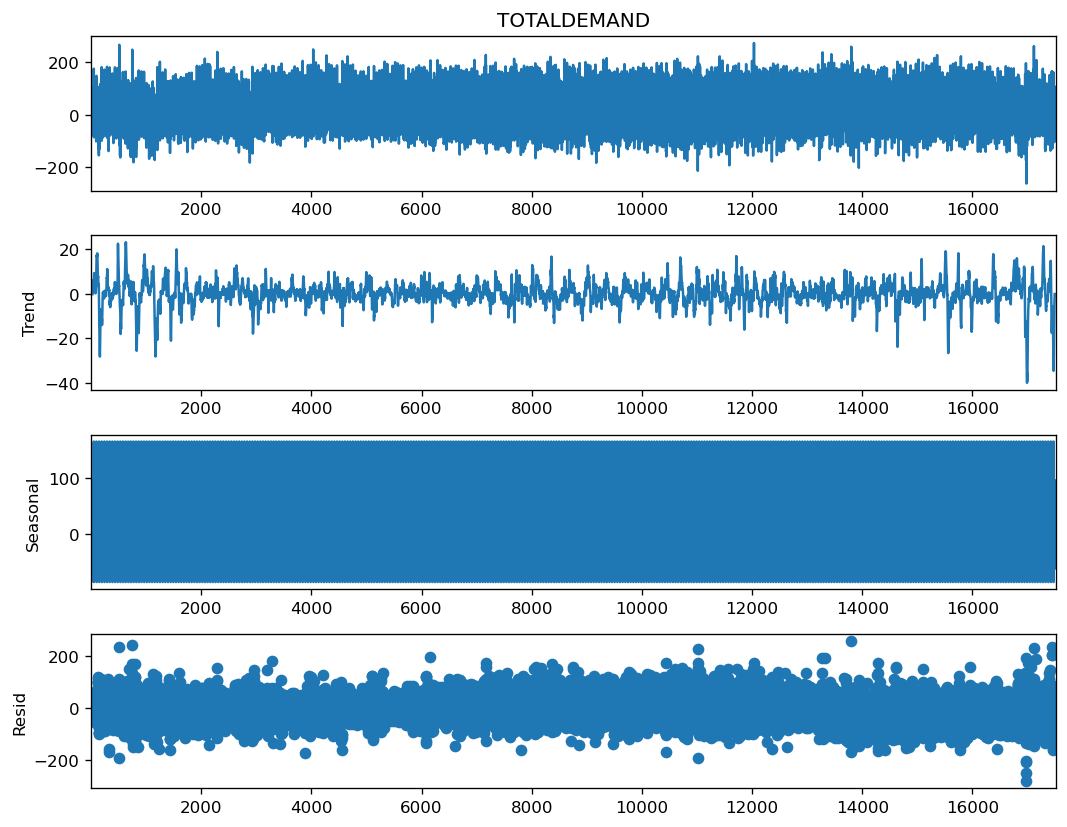

In [52]:
result_add = seasonal_decompose(demand_series.diff().dropna(), model='additive', period=48)
result_add.plot()
plt.show()

In [ ]:
#grid search hyperparameters p, q values ranging from 0 to 4. d=0 as stationary
sarima_fit = auto_arima(demand_sa_2019_df['TOTALDEMAND'], start_p=3, start_q=1, max_p=4, max_q=4,
                       m=48, stationary=False, start_P=0, seasonal=True, d=1, D=None, alpha=0.05, test='kpss', stepwise=True, information_criterion='aic',
                       n_jobs=1, method='lbfgs', suppress_warnings=True, trace=True, random_state=13, n_fits=25)

Performing stepwise search to minimize aic
 ARIMA(3,1,1)(0,0,1)[48] intercept   : AIC=183477.756, Time=73.20 sec
 ARIMA(0,1,0)(0,0,0)[48] intercept   : AIC=196721.682, Time=0.40 sec
 ARIMA(1,1,0)(1,0,0)[48] intercept   : AIC=inf, Time=48.83 sec
 ARIMA(0,1,1)(0,0,1)[48] intercept   : AIC=185289.439, Time=45.86 sec
 ARIMA(0,1,0)(0,0,0)[48]             : AIC=196719.683, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[48] intercept   : AIC=188302.405, Time=13.94 sec
 ARIMA(3,1,1)(1,0,1)[48] intercept   : AIC=inf, Time=262.38 sec
 ARIMA(3,1,1)(0,0,2)[48] intercept   : AIC=180779.164, Time=893.27 sec


MemoryError: Unable to allocate 1.28 GiB for an array with shape (99, 99, 17521) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1015, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
MemoryError: Unable to allocate 1.28 GiB for an array with shape (99, 99, 17521) and data type float64


In [ ]:
sarima_fit.summary()

In [2]:
##########################################################
##########################################################
#Testing

In [32]:
#SA Temperature
temp_sa_df = pd.read_csv('temprature_sa.csv')

In [4]:
#SA Demand
demand_sa_df = pd.read_csv('totaldemand_sa.csv')

In [5]:
#Convert DATETIME string to type datetime 
demand_sa_df['DATETIME'] = pd.to_datetime(demand_sa_df['DATETIME'])

#Break down Timestamp into new attributes
demand_sa_df['YEAR'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).year
demand_sa_df['MONTH'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).month
demand_sa_df['DAY'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).day
demand_sa_df['TIME'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).time

In [6]:
#Get winter 2019 data for model build
demand_sa_2019_df = demand_sa_df.loc[(demand_sa_df['YEAR'] == 2019)].reset_index()
demand_sa_winter_2019_df = demand_sa_2019_df.loc[(demand_sa_2019_df['MONTH'] == 6) | (demand_sa_2019_df['MONTH'] == 7) | (demand_sa_2019_df['MONTH'] == 8) ].reset_index()

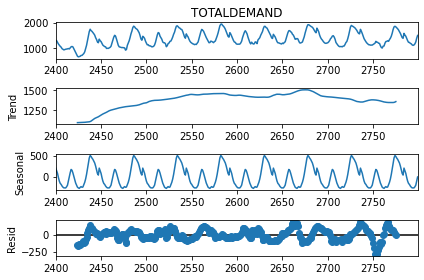

In [7]:
#Decompose time series (additive)
result_add = seasonal_decompose(demand_sa_winter_2019_df['TOTALDEMAND'].iloc[2400:2800], model='additive', period=48)
result_add.plot()
plt.show()

In [12]:
demand_sa_winter_2019_df.shape

(4416, 9)

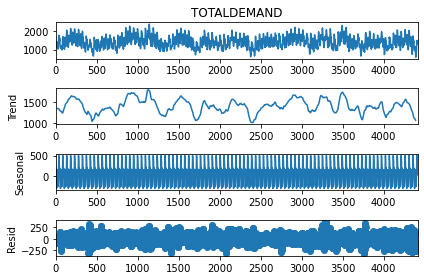

In [13]:
#Decompose time series (additive) across the whole data set
result_add = seasonal_decompose(demand_sa_winter_2019_df['TOTALDEMAND'], model='additive', period=48)
result_add.plot()
plt.show()

In [33]:
#Get training winter temperatures
#Convert DATETIME string to type datetime 
temp_sa_df['DATETIME'] = pd.to_datetime(temp_sa_df['DATETIME'])
iloc = (temp_sa_df['DATETIME'] >= '2020-06-01 00:00:00') & (temp_sa_df['DATETIME'] <= '2020-07-31 04:00:00')
temp_sa_train_winter = temp_sa_df.loc[iloc]

In [16]:
temp_sa_train_winter.tail(2)

,Unnamed: 0,LOCATION,DATETIME,TEMPERATURE
196256,196256,Adelaide (Kent Town),2020-07-31 03:30:00,9.4
196257,196257,Adelaide (Kent Town),2020-07-31 04:00:00,8.8


In [17]:
#Get preceding winter training data up to 31 July o400 hrs 2020
iloc = (demand_sa_df['DATETIME'] >= '2020-06-01 00:00:00') & (demand_sa_df['DATETIME'] <= '2020-07-31 04:00:00')

#Create and capture winter training demand 2020
demand_sa_train_winter = demand_sa_df.loc[iloc]

In [18]:
demand_sa_train_winter.head(2)

,DATETIME,TOTALDEMAND,REGIONID,YEAR,MONTH,DAY,TIME
182591,2020-06-01 00:00:00,1555.83,SA1,2020,6,1,00:00:00
182592,2020-06-01 00:30:00,1450.49,SA1,2020,6,1,00:30:00


In [24]:
temp_sa_train_winter.tail(2)

,Unnamed: 0,LOCATION,DATETIME,TEMPERATURE
196256,196256,Adelaide (Kent Town),2020-07-31 03:30:00,9.4
196257,196257,Adelaide (Kent Town),2020-07-31 04:00:00,8.8


In [22]:
temp_sa_train_winter.shape

(3263, 4)

In [23]:
demand_sa_train_winter.shape

(2889, 7)

In [34]:
#Break down Timestamp into new attributes
temp_sa_train_winter['MINUTES'] = pd.DatetimeIndex(temp_sa_train_winter['DATETIME']).minute

In [36]:
temp_sa_train_winter.tail(10)

,Unnamed: 0,LOCATION,DATETIME,TEMPERATURE,MINUTES
196248,196248,Adelaide (Kent Town),2020-07-30 23:30:00,10.6,30
196249,196249,Adelaide (Kent Town),2020-07-31 00:00:00,10.9,0
196250,196250,Adelaide (Kent Town),2020-07-31 00:30:00,10.0,30
196251,196251,Adelaide (Kent Town),2020-07-31 01:00:00,10.4,0
196252,196252,Adelaide (Kent Town),2020-07-31 01:30:00,10.3,30
196253,196253,Adelaide (Kent Town),2020-07-31 02:00:00,8.2,0
196254,196254,Adelaide (Kent Town),2020-07-31 02:30:00,9.3,30
196255,196255,Adelaide (Kent Town),2020-07-31 03:00:00,8.7,0
196256,196256,Adelaide (Kent Town),2020-07-31 03:30:00,9.4,30
196257,196257,Adelaide (Kent Town),2020-07-31 04:00:00,8.8,0


In [37]:
#Remove rows from Temp df where minutes != 0 or 30
minutes = [0, 30]
temp_sa_train_winter = temp_sa_train_winter[temp_sa_train_winter['MINUTES'].isin(minutes)]

In [38]:
temp_sa_train_winter.head()

,Unnamed: 0,LOCATION,DATETIME,TEMPERATURE,MINUTES
192995,192995,Adelaide (Kent Town),2020-06-01 00:00:00,12.4,0
192996,192996,Adelaide (Kent Town),2020-06-01 00:30:00,11.9,30
192997,192997,Adelaide (Kent Town),2020-06-01 01:00:00,13.0,0
192998,192998,Adelaide (Kent Town),2020-06-01 01:30:00,12.9,30
192999,192999,Adelaide (Kent Town),2020-06-01 02:00:00,12.3,0


In [39]:
temp_sa_train_winter.shape

(2887, 5)

In [42]:
demand_sa_train_winter.tail()

,DATETIME,TOTALDEMAND,REGIONID,YEAR,MONTH,DAY,TIME
185475,2020-07-31 02:00:00,1441.71,SA1,2020,7,31,02:00:00
185476,2020-07-31 02:30:00,1365.41,SA1,2020,7,31,02:30:00
185477,2020-07-31 03:00:00,1312.63,SA1,2020,7,31,03:00:00
185478,2020-07-31 03:30:00,1257.01,SA1,2020,7,31,03:30:00
185479,2020-07-31 04:00:00,1219.98,SA1,2020,7,31,04:00:00


In [45]:
#Find not common datetime values between demand and temperature df's
df = temp_sa_train_winter.merge(demand_sa_train_winter, how = 'outer' ,indicator=True).loc[lambda x : x['DATETIME']=='left_only']

In [47]:
#Merge demand and temp df's fy datetime
demand_temp_df = pd.merge_asof(demand_sa_train_winter, temp_sa_train_winter, on='DATETIME', direction='forward')

In [48]:
demand_temp_df.head()

,DATETIME,TOTALDEMAND,REGIONID,YEAR,MONTH,DAY,TIME,Unnamed: 0,LOCATION,TEMPERATURE,MINUTES
0,2020-06-01 00:00:00,1555.83,SA1,2020,6,1,00:00:00,192995,Adelaide (Kent Town),12.4,0
1,2020-06-01 00:30:00,1450.49,SA1,2020,6,1,00:30:00,192996,Adelaide (Kent Town),11.9,30
2,2020-06-01 01:00:00,1359.81,SA1,2020,6,1,01:00:00,192997,Adelaide (Kent Town),13.0,0
3,2020-06-01 01:30:00,1301.41,SA1,2020,6,1,01:30:00,192998,Adelaide (Kent Town),12.9,30
4,2020-06-01 02:00:00,1196.85,SA1,2020,6,1,02:00:00,192999,Adelaide (Kent Town),12.3,0


In [49]:
demand_temp_df.shape

(2889, 11)

In [52]:
#check null values
demand_temp_df[demand_temp_df.isna().any(axis=1)]

,DATETIME,TOTALDEMAND,REGIONID,YEAR,MONTH,DAY,TIME,Unnamed: 0,LOCATION,TEMPERATURE,MINUTES


In [54]:
#Check for duplicate DATATIME
demand_temp_df.DATETIME.duplicated().sum()

0

In [55]:
#Check for NaN Temps
demand_temp_df['TEMPERATURE'].isnull().sum()

0

In [56]:
import pmdarima as pm
#Consider another run with D=1
# SARIMAX Model
sxmodel = pm.auto_arima(demand_temp_df[['TOTALDEMAND']], exogenous=demand_temp_df[['TEMPERATURE']],
                           start_p=3, start_q=1, max_p=3, max_q=4,
                           test='adf',stationary=True,
                           m=48, information_criterion='aic',
                           start_P=0, seasonal=True,
                           d=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True, n_fits=25, random_state=13)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(3,0,1)(0,0,1)[48] intercept   : AIC=30385.329, Time=40.82 sec
 ARIMA(0,0,0)(0,0,0)[48] intercept   : AIC=41663.442, Time=0.39 sec
 ARIMA(1,0,0)(1,0,0)[48] intercept   : AIC=inf, Time=46.45 sec
 ARIMA(0,0,1)(0,0,1)[48] intercept   : AIC=inf, Time=29.23 sec
 ARIMA(0,0,0)(0,0,0)[48]             : AIC=44873.443, Time=0.44 sec
 ARIMA(3,0,1)(0,0,0)[48] intercept   : AIC=inf, Time=4.55 sec
 ARIMA(3,0,1)(1,0,1)[48] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,0,1)(0,0,2)[48] intercept   : AIC=inf, Time=196.10 sec
 ARIMA(3,0,1)(1,0,0)[48] intercept   : AIC=inf, Time=61.31 sec
 ARIMA(3,0,1)(1,0,2)[48] intercept   : AIC=inf, Time=230.20 sec
 ARIMA(2,0,1)(0,0,1)[48] intercept   : AIC=30623.764, Time=44.43 sec
 ARIMA(3,0,0)(0,0,1)[48] intercept   : AIC=30615.477, Time=39.61 sec
 ARIMA(3,0,2)(0,0,1)[48] intercept   : AIC=inf, Time=49.52 sec
 ARIMA(2,0,0)(0,0,1)[48] intercept   : AIC=30583.457, Time=41.14 sec
 ARIMA(2,0,2)(0,0,1)[48] intercept   : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2889
Model:             SARIMAX(3, 0, 1)x(0, 0, 1, 48)   Log Likelihood              -15184.664
Date:                            Tue, 22 Mar 2022   AIC                          30385.329
Time:                                    16:10:48   BIC                          30433.078
Sample:                                         0   HQIC                         30402.537
                                           - 2889                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       0.2374      0.488      0.487      0.626      -0.718       1.193
TEMPERATURE    -1.3500      0.937     -1.441      0.150      -3.186       0.486
ar.L1           2.6490      0.015    176.631      0.000       2.620       2.678
ar.L2          -2.3676      0.028    -83.933      0.000      -2.423      -2.312
ar.L3           0.7184      0.014     51.463      0.000       0.691       0.746
ma.L1          -0.9778      0.009   -109.824      0.000      -0.995      -0.960
ma.S.L48        0.5086      0.012     43.188      0.000       0.486       0.532
sigma2       2130.9129     43.702     48.760      0.000    2045.259    2216.567
===================================================================================
Ljung-Box (L1) (Q):                  59.30   Jarque-Bera (JB):               878.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.41
Prob(H) (two-sided):                  0.12   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
#Build final SARIMA model
model = ARIMA(demand_temp_df[['TOTALDEMAND']], demand_temp_df[['TEMPERATURE']], order=(3, 0, 0), seasonal_order=(1, 0, 1, 48))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        TOTALDEMAND   No. Observations:                 2889
Model:             ARIMA(3, 0, 0)x(1, 0, [1], 48)   Log Likelihood              -13934.244
Date:                            Tue, 22 Mar 2022   AIC                          27884.489
Time:                                    16:15:08   BIC                          27932.238
Sample:                                         0   HQIC                         27901.697
                                           - 2889                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1694.7912    246.063      6.888      0.000    1212.516    2177.066
TEMPERATURE    -0.5988      0.473     -1.265      0.206      -1.526       0.329
ar.L1           1.4740      0.014    104.781      0.000       1.446       1.502
ar.L2          -0.4383      0.024    -18.456      0.000      -0.485      -0.392
ar.L3          -0.0733      0.014     -5.211      0.000      -0.101      -0.046
ar.S.L48        0.9992      0.000   3818.219      0.000       0.999       1.000
ma.S.L48       -0.9355      0.010    -91.854      0.000      -0.955      -0.916
sigma2        864.2493     15.062     57.381      0.000     834.729     893.769
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              2137.92
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.03
Prob(H) (two-sided):                  0.85   Kurtosis:                         7.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [2]:
#Average demand forecast calculations

In [77]:
#SA Demand
demand_sa_df = pd.read_csv('totaldemand_sa.csv')

In [78]:
demand_sa_df['DATETIME'] = pd.to_datetime(demand_sa_df['DATETIME'])

In [79]:
#Get actual demand from 25.07.2020 0400 hrs til final prediction forcast time 31.07.2020 0400 hrs
iloc = (demand_sa_df['DATETIME'] > '2020-07-25 04:00:00') & (demand_sa_df['DATETIME'] <= '2020-07-31 04:00:00')
pre_forecast_6_day_demand_df = demand_sa_df.loc[iloc]

In [80]:
#Capture demand as list
pre_forecast_6_day_demand_lst = pre_forecast_6_day_demand_df['TOTALDEMAND'].tolist()

In [81]:
#Split demand list into 48 time steps list
pre_forecast_daily_demand_lst = [pre_forecast_6_day_demand_lst[i:i + 48] for i in range(0, len(pre_forecast_6_day_demand_lst), 48)]

In [82]:
len(pre_forecast_daily_demand_lst)

6

In [83]:
# Create the pandas DataFrame to hold daily demand time steps
daily_demand_ts_df = pd.DataFrame(pre_forecast_daily_demand_lst, columns = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27', 'T28', 'T29', 'T30', 'T31', 'T32', 'T33', 'T34', 'T35', 'T36', 'T37', 'T38', 'T39', '40', 'T41', 'T42', 'T43', 'T44', 'T45', 'T46', 'T47', 'T48',])

In [84]:
#Transpost df
daily_demand_ts_df_T = daily_demand_ts_df.T

In [85]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [87]:
#Add empty columns to df
daily_demand_ts_df_T['Mean'] = daily_demand_ts_df_T.apply(lambda _: '', axis=1)
daily_demand_ts_df_T['lCI'] = daily_demand_ts_df_T.apply(lambda _: '', axis=1)
daily_demand_ts_df_T['uCI'] = daily_demand_ts_df_T.apply(lambda _: '', axis=1)

In [93]:
daily_demand_ts_df_T[['Mean', 'lCI', 'uCI']] = daily_demand_ts_df_T.apply(lambda row : mean_confidence_interval([row[0],  row[1], row[2], row[3],  row[4], row[5]]), axis = 1).values.tolist()



In [94]:
daily_demand_ts_df_T

,0,1,2,3,4,5,Mean,lCI,uCI
T1,1275.54,1283.12,1205.83,1343.33,1340.17,1344.37,1298.726667,1240.862302,1356.591032
T2,1266.63,1278.61,1230.59,1347.70,1330.00,1351.16,1300.781667,1248.990542,1352.572792
T3,1276.97,1304.34,1231.96,1367.55,1352.70,1360.44,1315.660000,1258.756718,1372.563282
T4,1302.87,1319.44,1273.95,1423.13,1394.35,1411.16,1354.150000,1287.959168,1420.340832
T5,1346.53,1335.38,1342.91,1494.05,1463.91,1493.73,1412.751667,1330.074216,1495.429117
T6,1408.68,1368.56,1465.35,1659.71,1592.16,1629.91,1520.728333,1392.100044,1649.356623
T7,1461.81,1401.31,1596.57,1786.52,1757.25,1757.34,1626.800000,1452.107786,1801.492214
T8,1530.26,1449.36,1732.93,1960.05,1924.38,1897.63,1749.101667,1521.453641,1976.749693
T9,1620.40,1489.77,1851.51,2076.86,2017.07,1986.12,1840.288333,1592.024289,2088.552377
T10,1588.93,1486.02,1827.27,1988.80,2004.80,1938.51,1805.721667,1575.584133,2035.859200


In [2]:
#SA Forecast demand
forecast_sa_df = pd.read_csv('forecastdemand_sa.csv')

In [6]:
forecast_sa_df['DATETIME'] = pd.to_datetime(forecast_sa_df['DATETIME'])
forecast_sa_df['LASTCHANGED'] = pd.to_datetime(forecast_sa_df['LASTCHANGED'])

In [7]:
forecast_sa_df.head()

,PREDISPATCHSEQNO,REGIONID,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME
0,2016123018,SA1,71,1394.41,2016-12-30 12:31:25,2017-01-01 00:00:00
1,2016123018,SA1,72,1285.07,2016-12-30 12:31:25,2017-01-01 00:30:00
2,2016123018,SA1,73,1221.70,2016-12-30 12:31:25,2017-01-01 01:00:00
3,2016123018,SA1,74,1141.86,2016-12-30 12:31:25,2017-01-01 01:30:00
4,2016123018,SA1,75,1087.78,2016-12-30 12:31:25,2017-01-01 02:00:00


In [10]:
#Investigate last changed on 07.08.2020

iloc = (forecast_sa_df['LASTCHANGED'] > '2020-08-07 04:00:00') 
forecast_last_changed_df = forecast_sa_df.loc[iloc]
forecast_last_changed_df.head(48)

,PREDISPATCHSEQNO,REGIONID,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME
3502013,2020080701,SA1,1,1318.20,2020-08-07 04:01:25,2020-08-07 04:30:00
3502014,2020080701,SA1,2,1311.27,2020-08-07 04:01:25,2020-08-07 05:00:00
3502015,2020080701,SA1,3,1308.70,2020-08-07 04:01:25,2020-08-07 05:30:00
3502016,2020080701,SA1,4,1337.92,2020-08-07 04:01:25,2020-08-07 06:00:00
3502017,2020080701,SA1,5,1387.73,2020-08-07 04:01:25,2020-08-07 06:30:00
3502018,2020080701,SA1,6,1501.31,2020-08-07 04:01:25,2020-08-07 07:00:00
3502019,2020080701,SA1,7,1633.74,2020-08-07 04:01:25,2020-08-07 07:30:00
3502020,2020080701,SA1,8,1768.35,2020-08-07 04:01:25,2020-08-07 08:00:00
3502021,2020080701,SA1,9,1870.05,2020-08-07 04:01:25,2020-08-07 08:30:00
3502022,2020080701,SA1,10,1879.84,2020-08-07 04:01:25,2020-08-07 09:00:00
